In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## 1️⃣ Preparação básica e extração dos lat e long dos conjuntos de dados

In [3]:
imoveis = pd.read_csv(
    "/home/felipe/Projeto/Portfolio/Portfolio2/Regression_PriceHouse/data/pre/preprocessed.csv"
)

escolas = pd.read_csv("/home/felipe/Projeto/Portfolio/Portfolio2/Regression_PriceHouse/data/pre/escolas.csv")
hospitais = pd.read_csv("/home/felipe/Projeto/Portfolio/Portfolio2/Regression_PriceHouse/data/pre/hospitais.csv")
parques = pd.read_csv("/home/felipe/Projeto/Portfolio/Portfolio2/Regression_PriceHouse/data/pre/parques.csv")
farmacia = pd.read_csv("/home/felipe/Projeto/Portfolio/Portfolio2/Regression_PriceHouse/data/pre/farmacia.csv")
mercado = pd.read_csv("/home/felipe/Projeto/Portfolio/Portfolio2/Regression_PriceHouse/data/pre/mercados.csv")
policia = pd.read_csv("/home/felipe/Projeto/Portfolio/Portfolio2/Regression_PriceHouse/data/pre/policia.csv")

In [4]:


imoveis = imoveis.dropna(subset=["lat", "lon"])

In [5]:
from shapely import wkt

def extract_lat_lon_from_geometry(df, geometry_col="geometry"):
    """
    Extrai lat/lon de geometrias POINT ou POLYGON usando centróide
    """
    def get_lat_lon(geom_wkt):
        try:
            geom = wkt.loads(geom_wkt)

            # Para POINT, POLYGON, MULTIPOLYGON, etc
            point = geom.centroid

            return pd.Series({
                "lat": point.y,
                "lon": point.x
            })
        except:
            return pd.Series({
                "lat": None,
                "lon": None
            })

    coords = df[geometry_col].apply(get_lat_lon)
    df = pd.concat([df, coords], axis=1)

    return df



In [6]:
escolas_publicas = escolas[escolas["tipo_escola"] == "publica"].copy()
escolas_privadas = escolas[escolas["tipo_escola"] == "privada"].copy()


## 2️⃣ Aplicar aos POIs (antes de qualquer cálculo)

In [7]:
escolas_publicas = extract_lat_lon_from_geometry(escolas_publicas, geometry_col="geometry_std")
escolas_privadas = extract_lat_lon_from_geometry(escolas_privadas, geometry_col="geometry_std")
hospitais = extract_lat_lon_from_geometry(hospitais)
parques = extract_lat_lon_from_geometry(parques)
farmacia = extract_lat_lon_from_geometry(farmacia)
mercado = extract_lat_lon_from_geometry(mercado)
policia = extract_lat_lon_from_geometry(policia)


In [8]:
#validação rápida
escolas_publicas[["lat", "lon"]].describe()


,lat,lon
count,121.000000,121.000000
mean,-25.091286,-50.158007
std,0.028861,0.034239
min,-25.177780,-50.248422
25%,-25.105068,-50.178337
50%,-25.089461,-50.157134
75%,-25.069001,-50.132926
max,-25.040716,-50.089370


In [9]:
print(f'Proporção de geometrias do tipo POLYGON em escolas públicas: {escolas_publicas.geometry.str.contains("POLYGON").mean():.2%}')
print('\n')
print(f'Proporção de geometrias do tipo POLYGON em escolas privadas: {escolas_privadas.geometry.str.contains("POLYGON").mean():.2%}')

Proporção de geometrias do tipo POLYGON em escolas públicas: 14.88%


Proporção de geometrias do tipo POLYGON em escolas privadas: 66.67%


**👉 ~66,7% das escolas privadas** estão mapeadas como **POLYGON**

📖 Interpretação urbana:

* Grandes terrenos
* Campus definidos
* Infraestrutura mais organizada
* Geralmente condomínios fechados, colégios grandes, universidades privadas

**👉 ~14,9% das escolas públicas** são **POLYGON**
**👉 85% são apenas POINTS

📖 Interpretação urbana:

* Mapeamento incompleto
* Muitas escolas pequenas
* Cadastro público mais simples
* Muitas vezes só o endereço, não o perímetro

### Isso explica um efeito importante no modelo
Quando calculamos:

* distância até a escola
* buffer de 300m / 500m
* contagem de escolas no raio

⚠️ POLYGON vs POINT muda tudo

**Exemplos:**
Um POLYGON:
* já “encosta” no imóvel
* pode gerar distância zero
* entra em vários buffers

Um POINT:
* só conta se cair exatamente no raio
* não ocupa área urbana real

📌 Resultado:
**👉 escolas privadas estão “mais presentes” espacialmente
👉 escolas públicas ficam sub-representadas**

Isso pode:
* distorcer distâncias
* afetar contagens
* enviesar o score educacional

O modelo estava misturando:
* efeito socioeconômico da escola
* efeito geométrico da representação espacial

Isso é uma fonte clássica de viés em modelos urbanos baseados em OSM.

E isso foi detectado de forma empirica.


In [10]:
pois = {
    "escolas_publicas": escolas_publicas,
    "escolas_privadas": escolas_privadas,
    "hospitais": hospitais,
    "parques": parques,
    "farmacia": farmacia,
    "mercado": mercado,
    "policia": policia
}

for nome, df_poi in pois.items():
    if not {"lat", "lon"}.issubset(df_poi.columns):
        pois[nome] = extract_lat_lon_from_geometry(df_poi)



## 2️⃣ Função genérica (essa é a peça-chave)

**Usando Haversine + BallTree (rápido e correto geograficamente):**

In [11]:
def add_poi_features(
    imoveis_df,
    poi_df,
    prefix,
    radius_metros=[]
):
    """
    prefix: nome da categoria (ex: 'escola', 'hospital')
    radius_metros: lista de raios em metros para contagem
    """

    # Converter para radianos
    imoveis_coords = np.radians(imoveis_df[["lat", "lon"]].values)
    poi_coords = np.radians(poi_df[["lat", "lon"]].values)

    # Construir árvore
    tree = BallTree(poi_coords, metric="haversine")

    # Distância mínima
    dist, _ = tree.query(imoveis_coords, k=1)
    imoveis_df[f"dist_{prefix}_mais_proximo"] = dist[:, 0] * 6371000  # metros

    # Contagem por raio
    for r in radius_metros:
        count = tree.query_radius(
            imoveis_coords,
            r=r / 6371000,
            count_only=True
        )
        imoveis_df[f"qtd_{prefix}_{r}m"] = count

    return imoveis_df


## 3️⃣ Aplicar para cada categoria

In [12]:
imoveis = add_poi_features(
    imoveis,
    escolas_privadas,
    prefix="escolas_privadas",
    radius_metros=[500]
)


In [13]:
imoveis = add_poi_features(
    imoveis,
    escolas_publicas,
    prefix="escola_publicas",
    radius_metros=[500]
)

In [14]:
imoveis = add_poi_features(
    imoveis,
    policia,
    prefix="policia",
    radius_metros=[500]
)

In [15]:
imoveis = add_poi_features(
    imoveis,
    hospitais,
    prefix="hospital",
    radius_metros=[1000]
)


In [16]:
imoveis = add_poi_features(
    imoveis,
    mercado,
    prefix="mercado",
    radius_metros=[500]
)


In [17]:
imoveis = add_poi_features(
    imoveis,
    farmacia,
    prefix="farmacia",
    radius_metros=[300]
)


In [18]:
imoveis = add_poi_features(
    imoveis,
    parques,
    prefix="parque",
    radius_metros=[1000]
)


In [19]:
#imoveis.to_csv("/home/felipe/Projeto/Portfolio/Portfolio2/Regression_PriceHouse/data/processed/complete.csv")

imoveis

,preco,rua,endereco,quartos,banheiros,area_m2,link,cidade,estado,data_coleta,...,dist_policia_mais_proximo,qtd_policia_500m,dist_hospital_mais_proximo,qtd_hospital_1000m,dist_mercado_mais_proximo,qtd_mercado_500m,dist_farmacia_mais_proximo,qtd_farmacia_300m,dist_parque_mais_proximo,qtd_parque_1000m
0,2300000.0,Rua João Silvio de Lara Machado,"Sobrado para comprar com 354 m², 4 quartos, 5 ...",4.0,5.0,354.0,https://www.zapimoveis.com.br/imovel/venda-sob...,ponta-grossa,pr,2026-02-09 08:28:42,...,7.750486e+03,0,4.021543e+03,0,5.202898e+03,0,5.054262e+03,0,3.411460e+03,0
2,310000.0,Rua Jaguapitã,Lote/Terreno para comprar com 40 m² emBoa Vist...,NaN,NaN,40.0,https://www.zapimoveis.com.br/imovel/venda-ter...,ponta-grossa,pr,2026-02-09 08:28:42,...,1.680466e+03,0,1.729699e+03,0,1.096787e+03,0,1.729696e+03,0,2.158915e+02,2
3,350000.0,Rua Luiz Migdalski,"Casa de condomínio para comprar com 165 m², 4 ...",4.0,3.0,165.0,https://www.zapimoveis.com.br/imovel/venda-cas...,ponta-grossa,pr,2026-02-09 08:28:42,...,1.395976e+03,0,1.035952e+03,0,4.686538e+02,1,2.140548e+03,0,4.007913e+02,3
4,202696.0,Rua Eduardo Burgardt,Lote/Terreno para comprar com 200 m² emContorn...,NaN,NaN,200.0,https://www.zapimoveis.com.br/imovel/venda-ter...,ponta-grossa,pr,2026-02-09 08:28:42,...,4.610216e+03,0,3.884660e+03,0,3.838723e+03,0,6.728322e+03,0,1.708294e+02,2
5,340000.0,Rua Capitão Goes de Moraes,"Casa de condomínio para comprar com 80 m², 3 q...",3.0,2.0,80.0,https://www.zapimoveis.com.br/imovel/venda-cas...,ponta-grossa,pr,2026-02-09 08:28:42,...,5.688098e+02,0,1.372237e+03,0,2.986997e+02,1,2.197362e+03,0,3.975421e+02,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8595,400000.0,Avenida Souza Naves,"Lote/Terreno para comprar com 0 m² emChapada, ...",NaN,NaN,0.0,https://www.zapimoveis.com.br/imovel/venda-ter...,ponta-grossa,pr,2026-02-09 09:09:06,...,2.562017e+03,0,3.956130e+03,0,1.918938e+03,0,4.735699e+03,0,2.264813e+03,0
8596,1310000.0,Rua Lauro Marcondes Ferreira,"Casa para comprar com 310 m², 1 quarto, 1 banh...",1.0,1.0,310.0,https://www.zapimoveis.com.br/imovel/venda-cas...,ponta-grossa,pr,2026-02-09 09:09:06,...,1.551691e+03,0,1.355729e+03,0,6.631207e+02,0,2.526971e+02,1,2.548953e+02,7
8598,2700000.0,Rodovia BR-373,"Lote/Terreno para comprar com 10 m² emChapada,...",NaN,NaN,10.0,https://www.zapimoveis.com.br/imovel/venda-ter...,ponta-grossa,pr,2026-02-09 09:09:06,...,6.545851e+04,0,7.493626e+04,0,7.158290e+04,0,7.781041e+04,0,7.428626e+04,0
8599,1200000.0,Rua Benjamin Constant,"Apartamento para comprar com 123 m², 3 quartos...",3.0,3.0,123.0,https://www.zapimoveis.com.br/imovel/venda-apa...,ponta-grossa,pr,2026-02-09 09:09:06,...,2.542143e+02,1,8.056569e+02,4,1.452326e+02,1,6.119041e+01,1,1.923454e+02,15


## 5️⃣ Validação rápida

In [20]:
imoveis[
    imoveis["dist_escolas_privadas_mais_proximo"].isna()
].shape


(0, 32)

In [21]:
#ajustando o dataframe para valores e formatos corretos. 
df = imoveis

pd.options.display.float_format = '{:.2f}'.format

cols_candidatas = [
    'preco',
    'quartos',
    'banheiros',
    'area_m2',
    'vagas_garagem'
]

for col in cols_candidatas:
    df[col] = df[col].round().astype('Int64')
    
    
cat_cols = [
    'cidade', 'estado', 'bairro',
    'tipo_imovel', 'nivel_geocoding'
]

for col in cat_cols:
    df[col] = df[col].astype('category')


#Excluir a ultima linha do conjunto de dados. Claramente é um erro de coleta. 
df = df.iloc[:-1].copy()


In [22]:
df = df.select_dtypes(exclude='object')

df


,preco,quartos,banheiros,area_m2,cidade,estado,vagas_garagem,bairro,tipo_imovel,preco_m2,...,dist_policia_mais_proximo,qtd_policia_500m,dist_hospital_mais_proximo,qtd_hospital_1000m,dist_mercado_mais_proximo,qtd_mercado_500m,dist_farmacia_mais_proximo,qtd_farmacia_300m,dist_parque_mais_proximo,qtd_parque_1000m
0,2300000,4,5,354,ponta-grossa,pr,2,Jardim Carvalho,Sobrado,6497.18,...,7750.49,0,4021.54,0,5202.90,0,5054.26,0,3411.46,0
2,310000,<NA>,<NA>,40,ponta-grossa,pr,<NA>,Boa Vista,Lote/Terreno,7750.00,...,1680.47,0,1729.70,0,1096.79,0,1729.70,0,215.89,2
3,350000,4,3,165,ponta-grossa,pr,<NA>,Estrela,Casa de condomínio,2121.21,...,1395.98,0,1035.95,0,468.65,1,2140.55,0,400.79,3
4,202696,<NA>,<NA>,200,ponta-grossa,pr,<NA>,Contorno,Lote/Terreno,1013.48,...,4610.22,0,3884.66,0,3838.72,0,6728.32,0,170.83,2
5,340000,3,2,80,ponta-grossa,pr,1,Oficinas,Casa de condomínio,4250.00,...,568.81,0,1372.24,0,298.70,1,2197.36,0,397.54,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8593,2000000,8,5,370,ponta-grossa,pr,4,Boa Vista,Casa,5405.41,...,367.10,1,1227.71,0,856.26,0,2099.49,0,124.02,5
8595,400000,<NA>,<NA>,0,ponta-grossa,pr,<NA>,Chapada,Lote/Terreno,inf,...,2562.02,0,3956.13,0,1918.94,0,4735.70,0,2264.81,0
8596,1310000,1,1,310,ponta-grossa,pr,<NA>,Jardim Carvalho,Casa,4225.81,...,1551.69,0,1355.73,0,663.12,0,252.70,1,254.90,7
8598,2700000,<NA>,<NA>,10,ponta-grossa,pr,<NA>,Chapada,Lote/Terreno,270000.00,...,65458.51,0,74936.26,0,71582.90,0,77810.41,0,74286.26,0


In [23]:
df.filter(like="dist_").describe()



,dist_escolas_privadas_mais_proximo,dist_escola_publicas_mais_proximo,dist_policia_mais_proximo,dist_hospital_mais_proximo,dist_mercado_mais_proximo,dist_farmacia_mais_proximo,dist_parque_mais_proximo
count,8130.00,8130.00,8130.00,8130.00,8130.00,8130.00,8130.00
mean,1127470.59,1126954.43,1128223.61,1127877.21,1125620.39,1128424.16,1127062.93
std,3843644.04,3843871.73,3844258.05,3844075.75,3837890.19,3843918.19,3844002.63
min,21.02,18.74,25.61,25.35,32.77,38.56,0.10
25%,469.16,264.33,753.54,693.53,422.69,900.91,253.10
50%,889.20,434.86,1508.91,1294.63,733.54,1738.75,418.76
75%,1932.16,718.18,2666.05,2049.64,1439.10,3465.80,894.23
max,14253257.79,14253522.54,14256112.80,14255138.19,14231761.28,14255150.89,14254081.53


In [24]:
df.filter(like="qtd_").describe()

,qtd_escolas_privadas_500m,qtd_escola_publicas_500m,qtd_policia_500m,qtd_hospital_1000m,qtd_mercado_500m,qtd_farmacia_300m,qtd_parque_1000m
count,8130.00,8130.00,8130.00,8130.00,8130.00,8130.00,8130.00
mean,0.45,0.99,0.26,0.84,0.49,0.09,4.74
std,0.95,1.09,0.66,1.34,0.80,0.36,4.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,0.00,1.00,0.00,0.00,0.00,0.00,4.00
75%,1.00,1.00,0.00,1.00,1.00,0.00,8.00
max,5.00,5.00,4.00,5.00,4.00,2.00,15.00


In [25]:
df.tail()


,preco,quartos,banheiros,area_m2,cidade,estado,vagas_garagem,bairro,tipo_imovel,preco_m2,...,dist_policia_mais_proximo,qtd_policia_500m,dist_hospital_mais_proximo,qtd_hospital_1000m,dist_mercado_mais_proximo,qtd_mercado_500m,dist_farmacia_mais_proximo,qtd_farmacia_300m,dist_parque_mais_proximo,qtd_parque_1000m
8593,2000000,8,5,370,ponta-grossa,pr,4,Boa Vista,Casa,5405.41,...,367.10,1,1227.71,0,856.26,0,2099.49,0,124.02,5
8595,400000,<NA>,<NA>,0,ponta-grossa,pr,<NA>,Chapada,Lote/Terreno,inf,...,2562.02,0,3956.13,0,1918.94,0,4735.70,0,2264.81,0
8596,1310000,1,1,310,ponta-grossa,pr,<NA>,Jardim Carvalho,Casa,4225.81,...,1551.69,0,1355.73,0,663.12,0,252.70,1,254.90,7
8598,2700000,<NA>,<NA>,10,ponta-grossa,pr,<NA>,Chapada,Lote/Terreno,270000.00,...,65458.51,0,74936.26,0,71582.90,0,77810.41,0,74286.26,0
8599,1200000,3,3,123,ponta-grossa,pr,2,Centro,Apartamento,9756.10,...,254.21,1,805.66,4,145.23,1,61.19,1,192.35,15


## Normalização de nomes (primeiro passo) - Tratando os tipos de imóveis

In [26]:
df["tipo_imovel"].value_counts()

tipo_imovel
Apartamento                 2264
Casa                        2114
Lote/Terreno                1660
Sobrado                      735
Casa de condomínio           680
Sala/Conjunto                174
Imóvel comercial              95
Ponto comercial/Loja/Box      78
Cobertura                     74
Galpão/Depósito/Armazém       71
Casa de Vila                  31
Fazenda/Sítio/Chácara         21
Prédio/Edificio inteiro       15
Flat                           7
Imóvel                         6
Prédio/Edifício inteiro        6
Kitnet/Conjugado               4
Duplex                         3
Edifício residencial           3
Name: count, dtype: int64

In [27]:
def classificar_tipo_imovel(tipo):
    if pd.isna(tipo):
        return "outros"

    tipo = str(tipo).lower()

    if "terreno" in tipo or "lote" in tipo:
        return "terreno"

    if any(x in tipo for x in ["apartamento", "cobertura", "duplex", "flat", "kitnet"]):
        return "apartamento"

    if any(x in tipo for x in ["casa", "sobrado", "vila"]):
        return "casa"

    if any(x in tipo for x in ["comercial", "loja", "box", "galpão", "deposito", "depósito", "sala", "conjunto"]):
        return "comercial"

    if "prédio" in tipo or "edificio" in tipo or "edifício" in tipo:
        return "predio"

    return "outros"


df["tipo_imovel_cat"] = df["tipo_imovel"].apply(classificar_tipo_imovel)


In [28]:
#Removendo para evitar duplicidade
df = df.drop(columns=["tipo_imovel"])

In [29]:
df["tipo_imovel_cat"].value_counts(normalize=True)


tipo_imovel_cat
casa          0.44
apartamento   0.29
terreno       0.21
comercial     0.05
outros        0.00
predio        0.00
Name: proportion, dtype: float64

In [30]:
#Filtrando apenas casa, apartamento e sala comerical
df = df[
    df["tipo_imovel_cat"].isin(["casa", "apartamento", "comercial"])
].copy()


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6330 entries, 0 to 8599
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   preco                               6330 non-null   Int64   
 1   quartos                             6050 non-null   Int64   
 2   banheiros                           6237 non-null   Int64   
 3   area_m2                             6330 non-null   Int64   
 4   cidade                              6330 non-null   category
 5   estado                              6330 non-null   category
 6   vagas_garagem                       5610 non-null   Int64   
 7   bairro                              6330 non-null   category
 8   preco_m2                            6330 non-null   float64 
 9   lat                                 6330 non-null   float64 
 10  lon                                 6330 non-null   float64 
 11  nivel_geocoding                    

## EDA - Exploratory Data Analises

## 1️⃣ Plano de Análise

Objetivo: **entender o comportamento do preço dos imóveis** e quais variáveis:

* explicam melhor

* são não-lineares

* precisam de transformação

* devem ser mantidas / removidas

Vamos sempre perguntar:

* *Isso ajuda a explicar o preço?*


### Estatística Descritiva

In [32]:
#Antes de iniciar, vamos transformar o preço em log
df['log_preco'] = np.log(df['preco'].clip(lower=1))

In [33]:
dist_cols = [
    'dist_escolas_privadas_mais_proximo',
    'dist_escola_publicas_mais_proximo',
    'dist_policia_mais_proximo',
    'dist_hospital_mais_proximo',
    'dist_mercado_mais_proximo',
    'dist_farmacia_mais_proximo',
    'dist_parque_mais_proximo'
]

df = df[
    df[dist_cols].max(axis=1) < 100_000
].copy()


In [34]:
# Função atualizada para calcular estatísticas detalhadas para todas as colunas numéricas
def detailed_statistics_df(df):
    stats = []
    for column in df.select_dtypes(include='number').columns:
        column_stats = {
            'Variável': column,
            'Média': df[column].mean(),
            'Mediana': df[column].median(),
            'Moda': df[column].mode().iloc[0] if not df[column].mode().empty else None,
            'Desvio Padrão': df[column].std(),
            'Variância': df[column].var(),
            'Assimetria': df[column].skew(),
            'Curtose': df[column].kurt(),
            'Valor Mínimo': df[column].min(),
            'Valor Máximo': df[column].max(),
            'Amplitude': df[column].max() - df[column].min()
        }
        stats.append(column_stats)
    return pd.DataFrame(stats)

# Aplicando a função no DataFrame de exemplo
statistics_df = detailed_statistics_df(df)
statistics_df

/home/felipe/anaconda3/envs/regression/lib/python3.12/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/felipe/anaconda3/envs/regression/lib/python3.12/site-packages/pandas/core/nanops.py:1248: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean
/home/felipe/anaconda3/envs/regression/lib/python3.12/site-packages/pandas/core/nanops.py:1336: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


,Variável,Média,Mediana,Moda,Desvio Padrão,Variância,Assimetria,Curtose,Valor Mínimo,Valor Máximo,Amplitude
0,preco,836890.79,550000.00,450000.00,1155194.15,1334473514881.87,23.92,1109.23,85000.00,58750000.00,58665000.00
1,quartos,2.85,3.00,3.00,0.92,0.85,3.02,42.23,1.00,21.00,20.00
2,banheiros,2.24,2.00,1.00,1.38,1.91,2.92,36.27,1.00,30.00,29.00
3,area_m2,318.87,130.00,60.00,7507.57,56363662.96,56.14,3241.79,0.00,470000.00,470000.00
4,vagas_garagem,2.14,2.00,2.00,1.67,2.78,10.33,237.79,1.00,49.00,48.00
5,preco_m2,inf,4444.44,5000.00,NaN,NaN,NaN,NaN,3.69,inf,inf
6,lat,-25.10,-25.09,-25.10,0.03,0.00,6.21,173.83,-25.28,-24.34,0.94
7,lon,-50.16,-50.16,-50.16,0.03,0.00,-5.00,120.00,-50.92,-50.05,0.87
8,dist_escolas_privadas_mais_proximo,1161.32,736.66,526.12,2327.59,5417666.17,27.39,1010.47,21.02,92978.40,92957.39
9,qtd_escolas_privadas_500m,0.54,0.00,0.00,1.00,1.01,2.46,6.51,0.00,5.00,5.00


## 2️⃣ Análise Univariada

### Média e mediana dos preços por bairro

/tmp/ipykernel_14187/3465113848.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.index, y=top_brands.values, palette='viridis', order=top_brands.index)


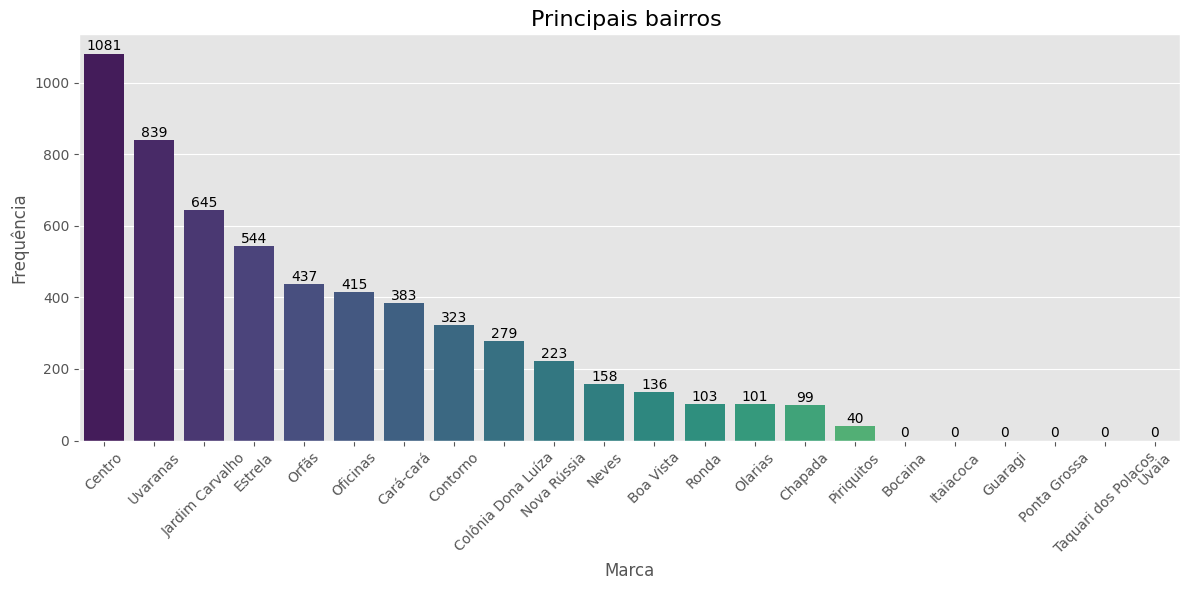

/tmp/ipykernel_14187/3465113848.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_percentages.index, y=brand_percentages.values, palette='viridis', order=brand_percentages.index)


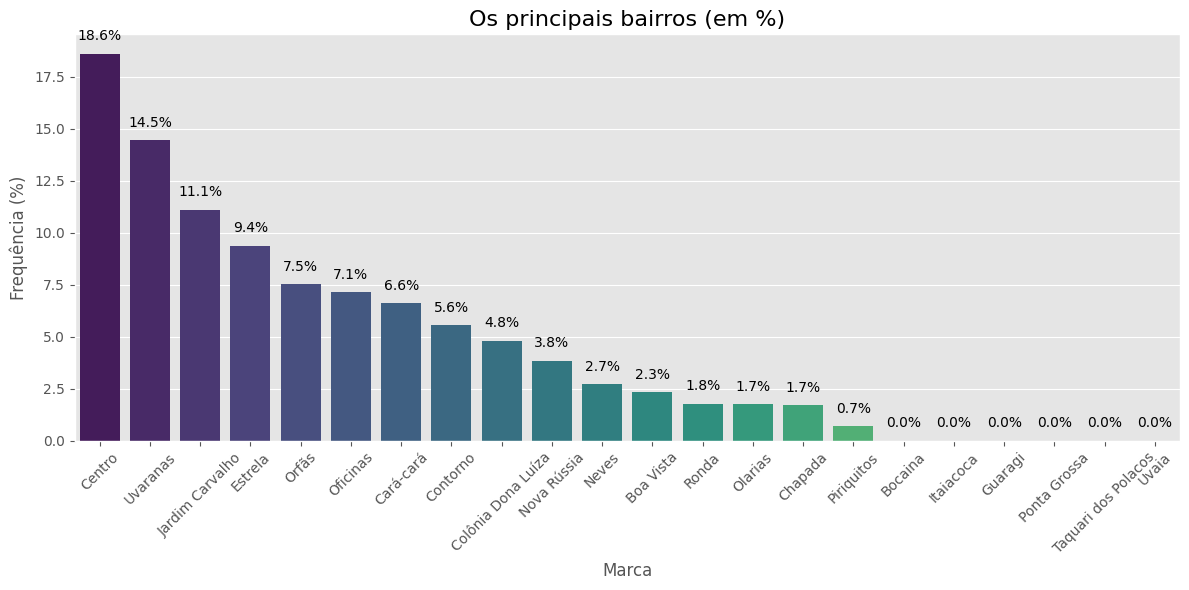

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obter as 25 marcas mais frequentes
top_brands = df['bairro'].value_counts()

# Configurar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=top_brands.index, y=top_brands.values, palette='viridis', order=top_brands.index)

# Adicionar valores no topo de cada barra
for i, value in enumerate(top_brands.values):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10, color='black')

# Personalizar o gráfico
plt.title('Principais bairros ', fontsize=16)
plt.xlabel('Marca', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

print('\n')

# Calcular a frequência percentual
brand_percentages = (df['bairro'].value_counts(normalize=True) * 100).head(25)

# Configurar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=brand_percentages.index, y=brand_percentages.values, palette='viridis', order=brand_percentages.index)

# Adicionar valores percentuais no topo de cada barra
for i, value in enumerate(brand_percentages.values):
    plt.text(i, value + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=10, color='black')

# Personalizar o gráfico
plt.title('Os principais bairros (em %)', fontsize=16)
plt.xlabel('Marca', fontsize=12)
plt.ylabel('Frequência (%)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

/tmp/ipykernel_14187/3031370552.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.index, y=top_brands.values, palette='viridis', order=top_brands.index)


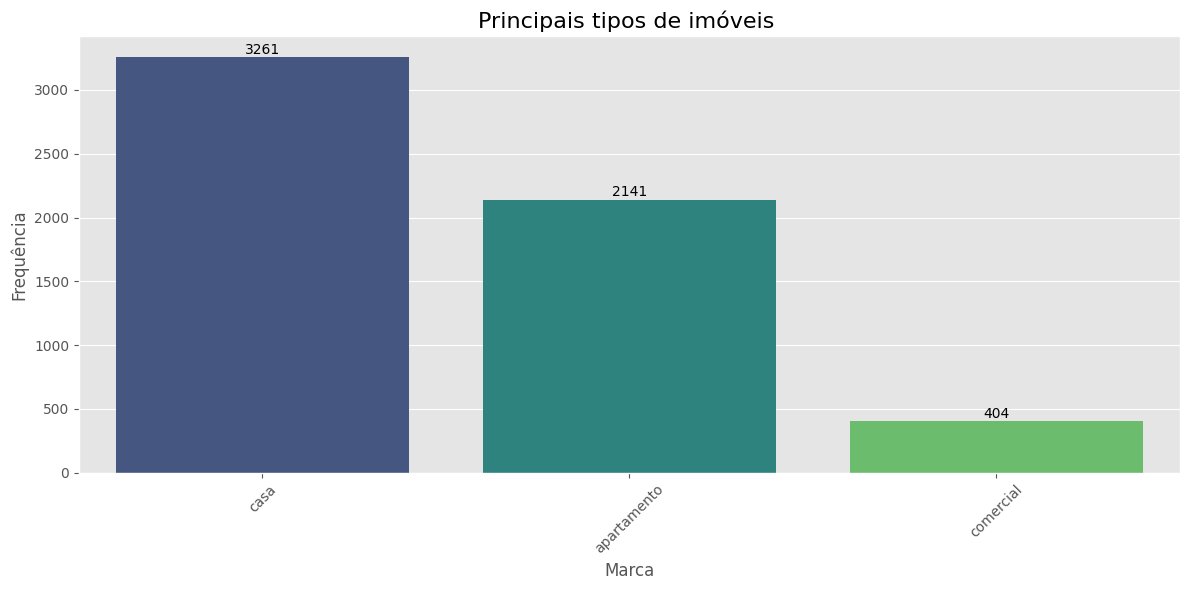

/tmp/ipykernel_14187/3031370552.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_percentages.index, y=brand_percentages.values, palette='viridis', order=brand_percentages.index)


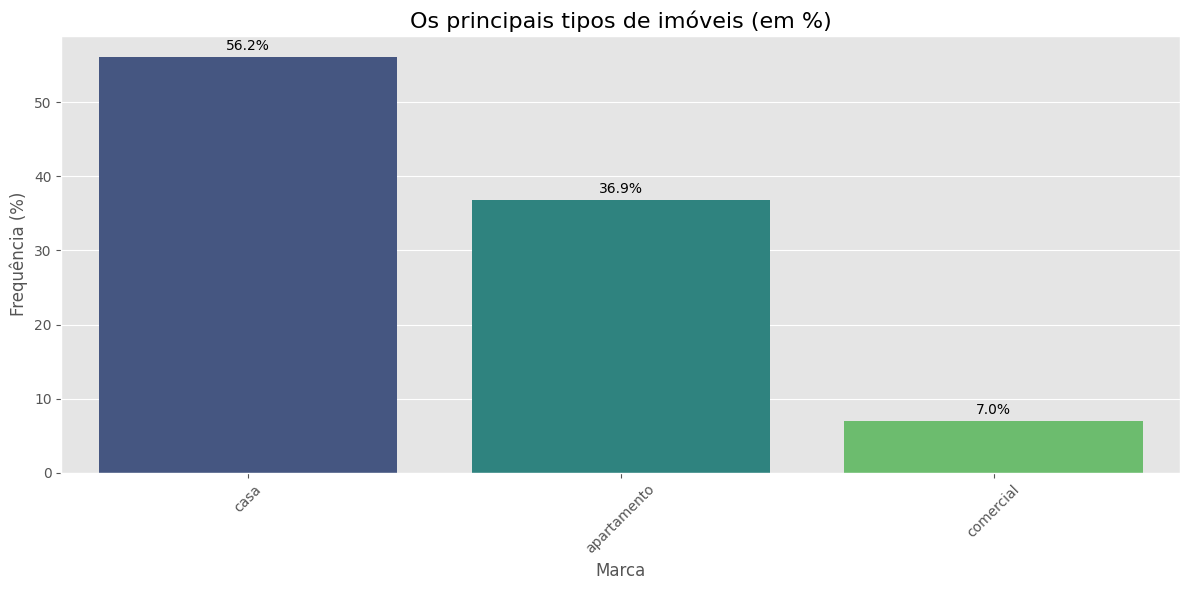

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obter as 25 marcas mais frequentes
top_brands = df['tipo_imovel_cat'].value_counts()

# Configurar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=top_brands.index, y=top_brands.values, palette='viridis', order=top_brands.index)

# Adicionar valores no topo de cada barra
for i, value in enumerate(top_brands.values):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10, color='black')

# Personalizar o gráfico
plt.title('Principais tipos de imóveis ', fontsize=16)
plt.xlabel('Marca', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

print('\n')

# Calcular a frequência percentual
brand_percentages = (df['tipo_imovel_cat'].value_counts(normalize=True) * 100).head(25)

# Configurar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=brand_percentages.index, y=brand_percentages.values, palette='viridis', order=brand_percentages.index)

# Adicionar valores percentuais no topo de cada barra
for i, value in enumerate(brand_percentages.values):
    plt.text(i, value + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=10, color='black')

# Personalizar o gráfico
plt.title('Os principais tipos de imóveis (em %)', fontsize=16)
plt.xlabel('Marca', fontsize=12)
plt.ylabel('Frequência (%)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

/tmp/ipykernel_14187/4203275910.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('bairro')


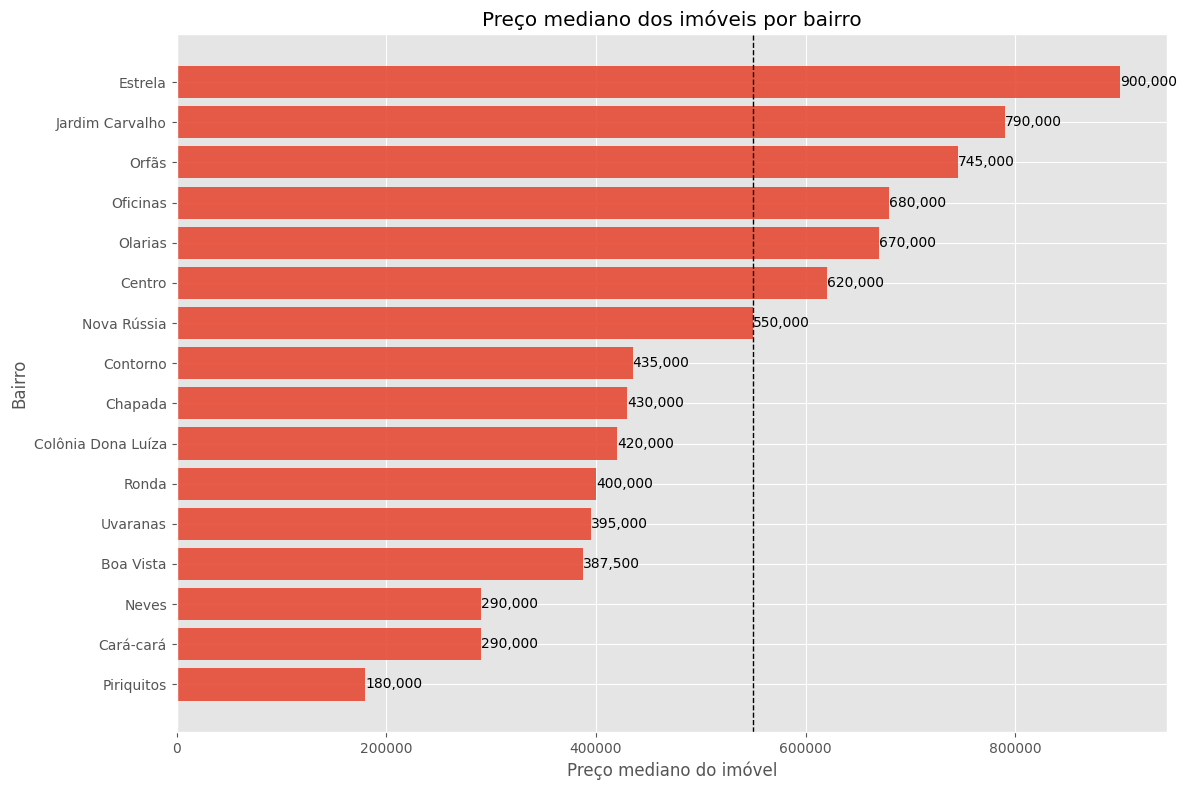

In [37]:
bairro_stats = (
    df.groupby('bairro')
    .agg(
        mediana_preco=('preco', 'median'),
        media_preco=('preco', 'mean'),
        n=('preco', 'count')
    )
    .query('n >= 30')                 # evita ruído
    .sort_values('mediana_preco')     # ordena para leitura
)

mediana_geral = df['preco'].median()

plt.figure(figsize=(12, 8))

plt.barh(
    bairro_stats.index,
    bairro_stats['mediana_preco'],
    color='#E64B35',
    alpha=0.9
)

# Linha vertical de referência
plt.axvline(
    mediana_geral,
    color='black',
    linestyle='--',
    linewidth=1
)

# Anotar valores nas barras
for i, v in enumerate(bairro_stats['mediana_preco']):
    plt.text(
        v,
        i,
        f'{v:,.0f}',
        va='center',
        ha='left',
        fontsize=10
    )

plt.xlabel('Preço mediano do imóvel')
plt.ylabel('Bairro')
plt.title('Preço mediano dos imóveis por bairro')

plt.tight_layout()
plt.show()

In [38]:
# 2.2 Categórica x Numérica
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='preco',
    y='bairro',
    data=df,
    order=ordem_bairros,
    showfliers=False
)

plt.title('Distribuição do valor por bairro (sem outliers)')
plt.xlabel('Valor')
plt.ylabel('Bairro')
plt.show()



coluna = 'preco'  # variável que quer analisar

Q1 = df[coluna].quantile(0.25)
Q3 = df[coluna].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]

print(f"Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}")
print(f"Limite inferior = {limite_inferior:.2f}, Limite superior = {limite_superior:.2f}")
print(f"Total de outliers: {len(outliers)}")

NameError: name 'ordem_bairros' is not defined

<Figure size 1200x800 with 0 Axes>

/home/felipe/anaconda3/envs/regression/lib/python3.12/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


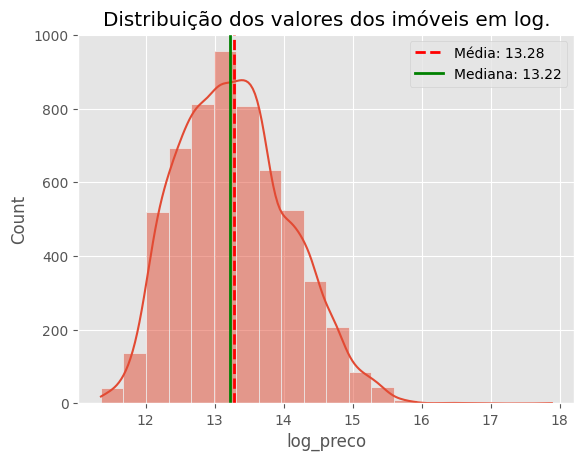

In [39]:
num_cols = [
    'preco', 'preco_m2', 'area_m2', 'quartos', 'banheiros', 'vagas_garagem',
    'dist_escolas_privadas_mais_proximo',
    'dist_escola_publicas_mais_proximo',
    'dist_policia_mais_proximo',
    'dist_hospital_mais_proximo',
    'dist_mercado_mais_proximo',
    'dist_farmacia_mais_proximo',
    'dist_parque_mais_proximo'
]

df[num_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

# Distribuição de satisfaction
ax = sns.histplot(df['log_preco'], bins=20, kde=True)
plt.title(f'Distribuição dos valores dos imóveis em log.')

# Calcular média e mediana
media = df['log_preco'].mean()
mediana = df['log_preco'].median()

# Adicionar linhas verticais
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Média: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')

plt.legend()
plt.show()


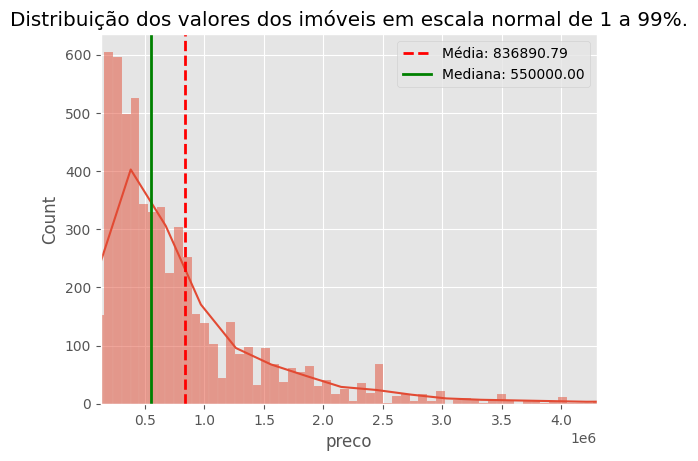

In [46]:
p1, p99 = df['preco'].quantile([0.01, 0.99])

# Distribuição de satisfaction
ax = sns.histplot(df['preco'], bins=800, kde=True)
plt.xlim(p1, p99)
plt.title(f'Distribuição dos valores dos imóveis em escala normal de 1 a 99%.')

# Calcular média e mediana
media = df['preco'].mean()
mediana = df['preco'].median()

# Adicionar linhas verticais
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Média: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')

plt.legend()
plt.show()

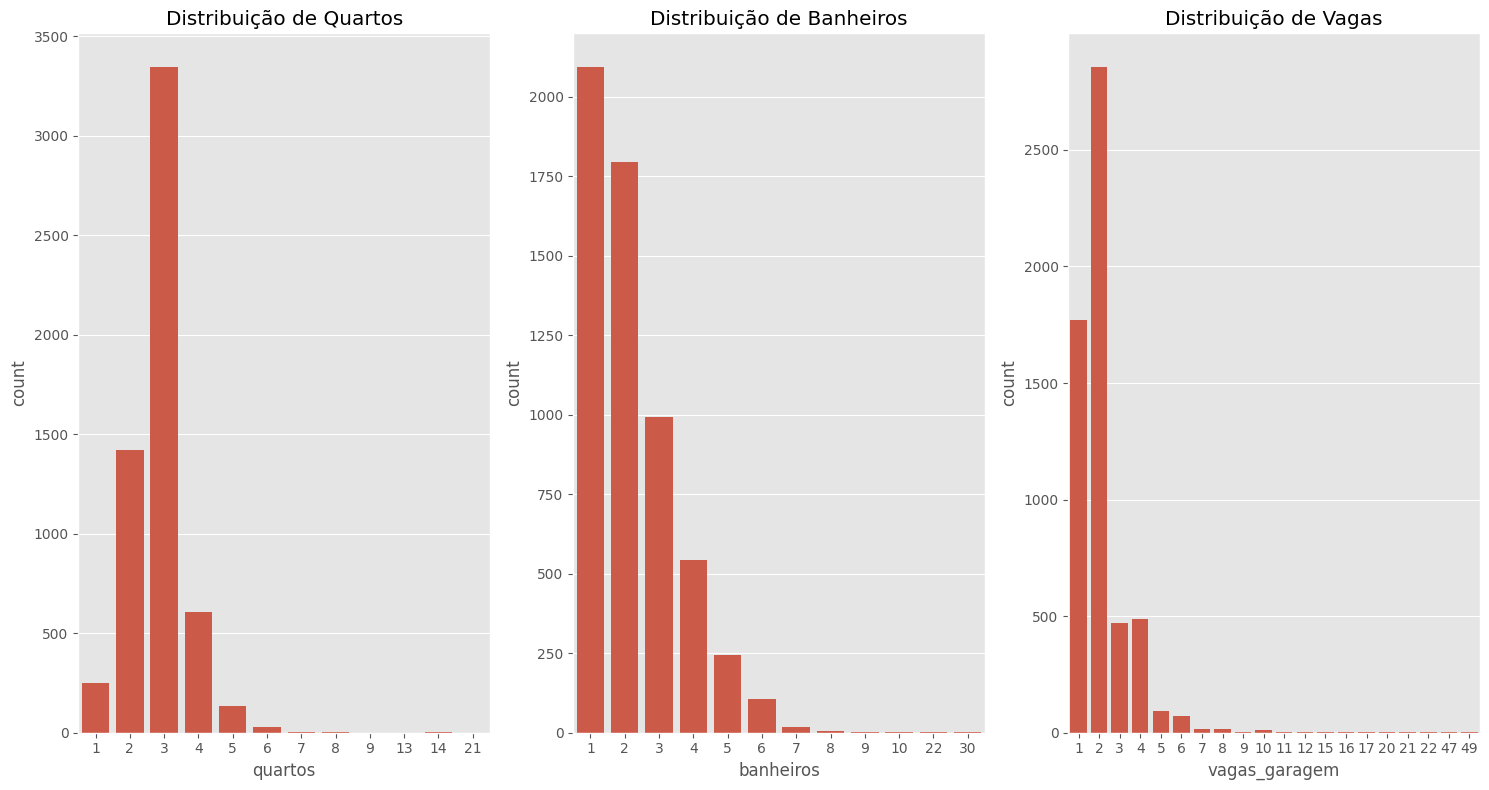

In [48]:
# 1. Primeiro, vamos verificar a mediana de cada coluna
mediana_quartos = df['quartos'].median()
mediana_banheiros = df['banheiros'].median()
mediana_vagas = df['vagas_garagem'].median()

# 2. Imputar os valores faltantes com a mediana
df['quartos'] = df['quartos'].fillna(mediana_quartos)
df['banheiros'] = df['banheiros'].fillna(mediana_banheiros)
df['vagas_garagem'] = df['vagas_garagem'].fillna(mediana_vagas)

# 3. Converter para inteiro (se quiser)
df['quartos'] = df['quartos'].astype('Int64')
df['banheiros'] = df['banheiros'].astype('Int64')
df['vagas_garagem'] = df['vagas_garagem'].astype('Int64')


fig, axes = plt.subplots(1, 3, figsize=(15,8))

sns.countplot(x='quartos', data=df, ax=axes[0])
axes[0].set_title('Distribuição de Quartos')

sns.countplot(x='banheiros', data=df, ax=axes[1])
axes[1].set_title('Distribuição de Banheiros')

sns.countplot(x='vagas_garagem', data=df, ax=axes[2])
axes[2].set_title('Distribuição de Vagas')

plt.tight_layout()
plt.show()


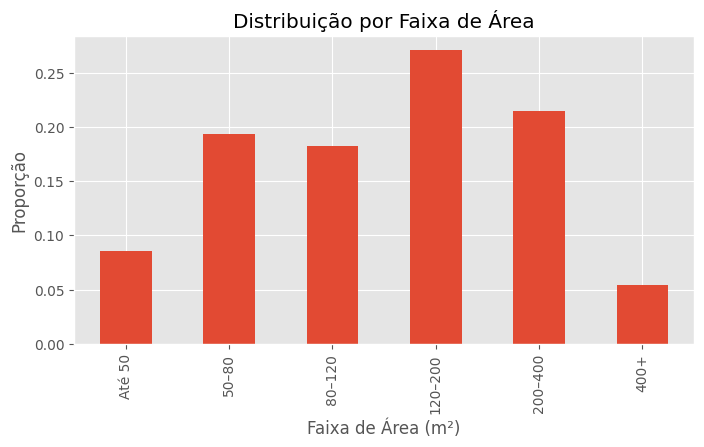

In [50]:
area = df['area_m2']

bins = [0, 50, 80, 120, 200, 400, area.max()]
labels = ['Até 50', '50–80', '80–120', '120–200', '200–400', '400+']

df['faixa_area'] = pd.cut(area, bins=bins, labels=labels)

df['faixa_area'].value_counts(normalize=True).sort_index()

plt.figure(figsize=(8,4))
df['faixa_area'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title('Distribuição por Faixa de Área')
plt.ylabel('Proporção')
plt.xlabel('Faixa de Área (m²)')
plt.show()


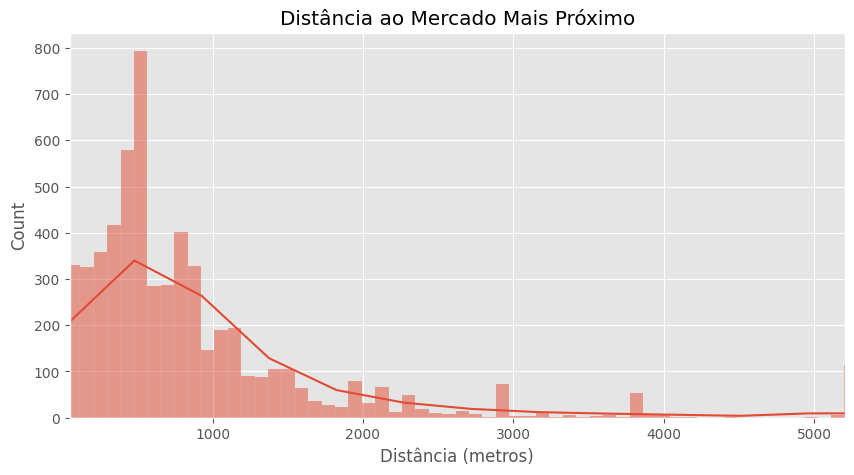

In [104]:
p1, p99 = df['dist_mercado_mais_proximo'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['dist_mercado_mais_proximo'], bins=1000, kde=True)
plt.xlim(p1, p99)
plt.title('Distância ao Mercado Mais Próximo')
plt.xlabel('Distância (metros)')
plt.show()


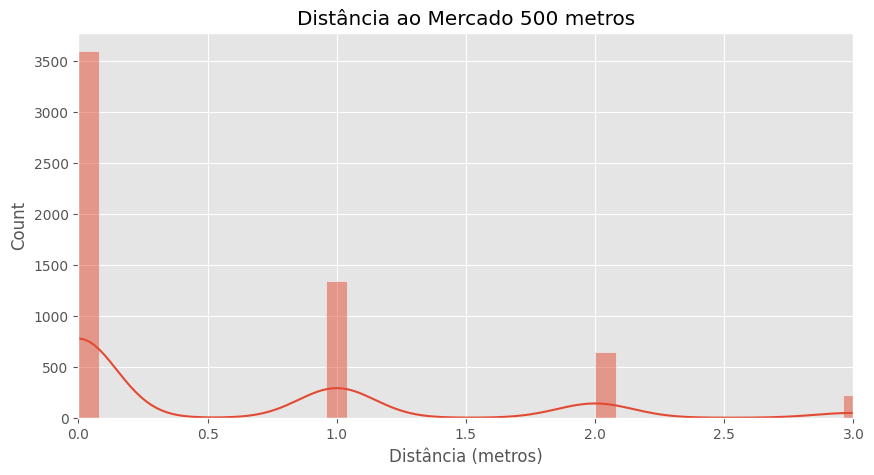

In [92]:
p1, p99 = df['qtd_mercado_500m'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['qtd_mercado_500m'], bins=50, kde=True)
plt.xlim(p1, p99)
plt.title('Distância ao Mercado 500 metros')
plt.xlabel('Distância (metros)')
plt.show()

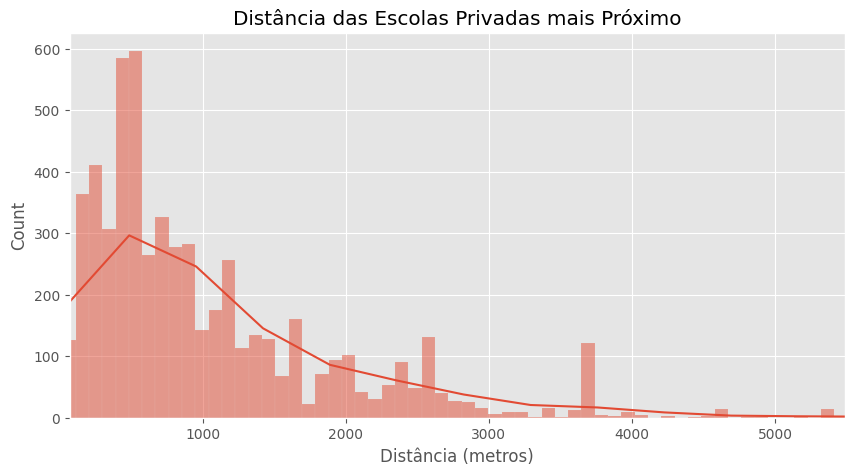

In [103]:
p1, p99 = df['dist_escolas_privadas_mais_proximo'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['dist_escolas_privadas_mais_proximo'], bins=1000, kde=True)
plt.xlim(p1, p99)
plt.title('Distância das Escolas Privadas mais Próximo')
plt.xlabel('Distância (metros)')
plt.show()

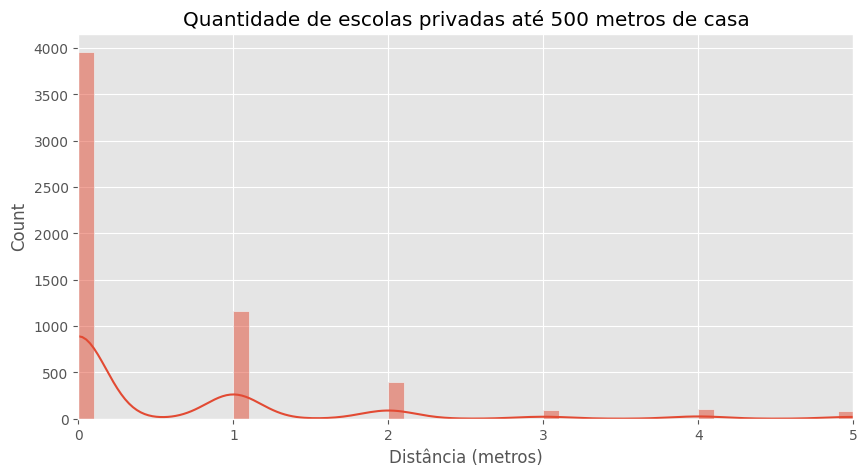

In [93]:
p1, p99 = df['qtd_escolas_privadas_500m'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['qtd_escolas_privadas_500m'], bins=50, kde=True)
plt.xlim(p1, p99)
plt.title('Quantidade de escolas privadas até 500 metros de casa')
plt.xlabel('Distância (metros)')
plt.show()

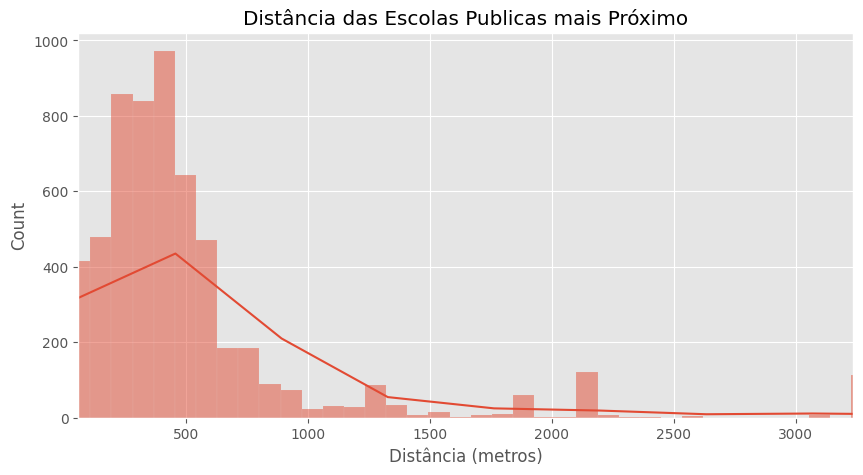

In [102]:
p1, p99 = df['dist_escola_publicas_mais_proximo'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['dist_escola_publicas_mais_proximo'], bins=1000, kde=True)
plt.xlim(p1, p99)
plt.title('Distância das Escolas Publicas mais Próximo')
plt.xlabel('Distância (metros)')
plt.show()

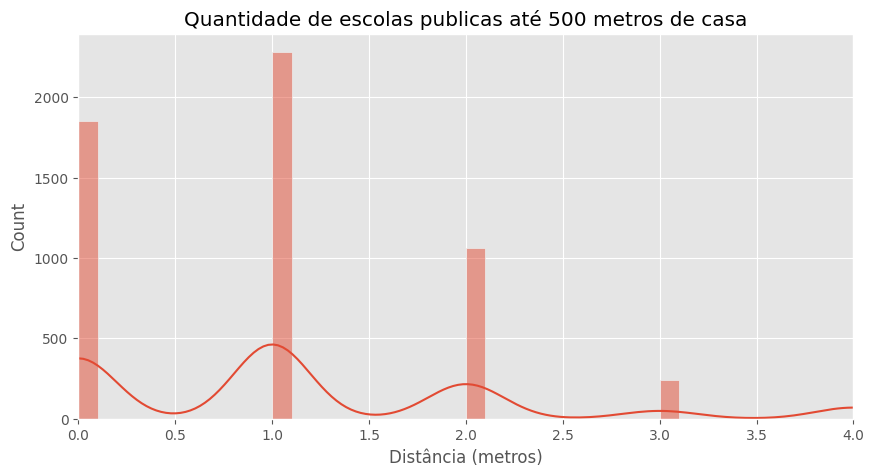

In [97]:
p1, p99 = df['qtd_escola_publicas_500m'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['qtd_escola_publicas_500m'], bins=50, kde=True)
plt.xlim(p1, p99)
plt.title('Quantidade de escolas publicas até 500 metros de casa')
plt.xlabel('Distância (metros)')
plt.show()

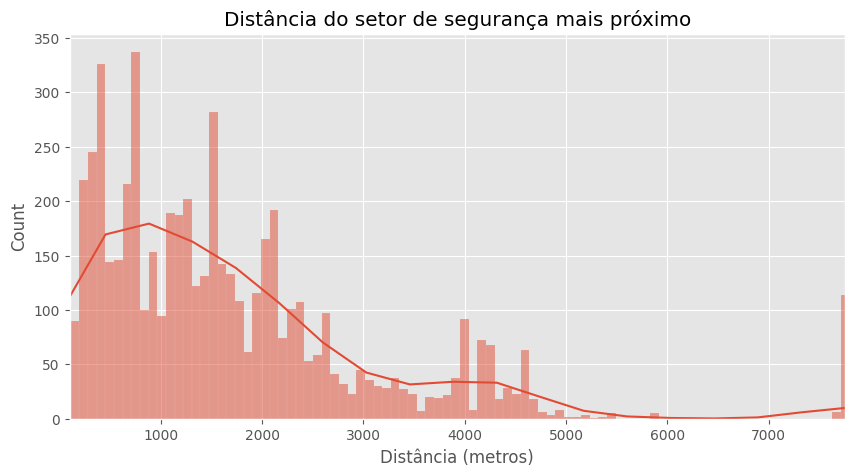

In [105]:
p1, p99 = df['dist_policia_mais_proximo'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['dist_policia_mais_proximo'], bins=1000, kde=True)
plt.xlim(p1, p99)
plt.title('Distância do setor de segurança mais próximo')
plt.xlabel('Distância (metros)')
plt.show()

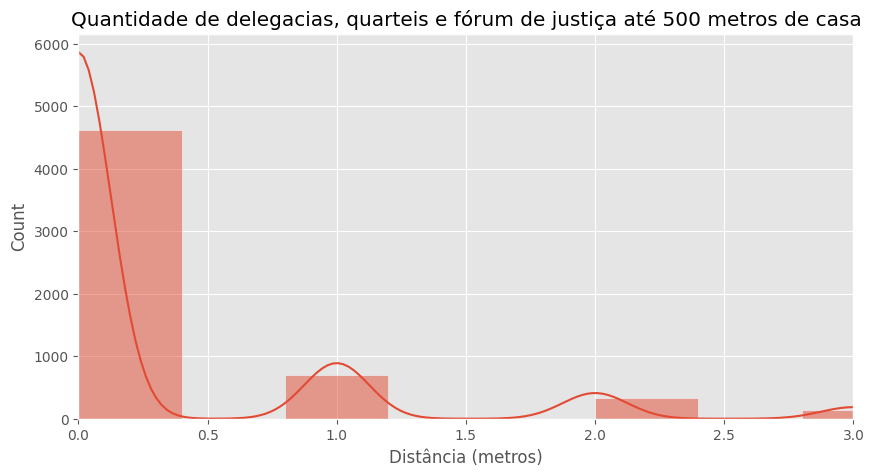

In [106]:
p1, p99 = df['qtd_policia_500m'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['qtd_policia_500m'], bins=10, kde=True)
plt.xlim(p1, p99)
plt.title('Quantidade de delegacias, quarteis e fórum de justiça até 500 metros de casa')
plt.xlabel('Distância (metros)')
plt.show()

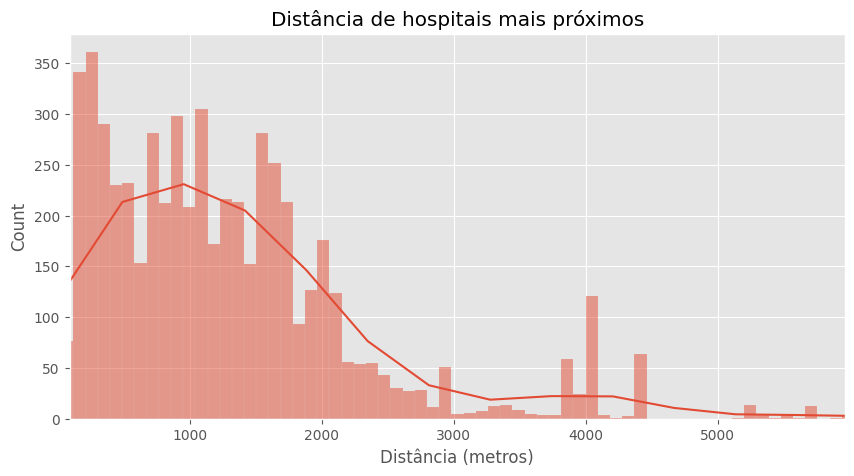

In [107]:
p1, p99 = df['dist_hospital_mais_proximo'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['dist_hospital_mais_proximo'], bins=1000, kde=True)
plt.xlim(p1, p99)
plt.title('Distância de hospitais mais próximos')
plt.xlabel('Distância (metros)')
plt.show()

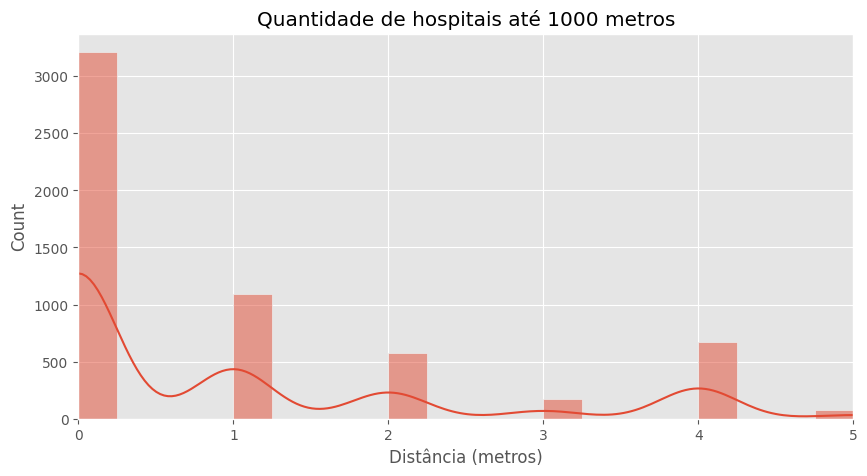

In [111]:
p1, p99 = df['qtd_hospital_1000m'].quantile([0.01, 0.99])

plt.figure(figsize=(10,5))
sns.histplot(df['qtd_hospital_1000m'], bins=20, kde=True)
plt.xlim(p1, p99)
plt.title('Quantidade de hospitais até 1000 metros')
plt.xlabel('Distância (metros)')
plt.show()

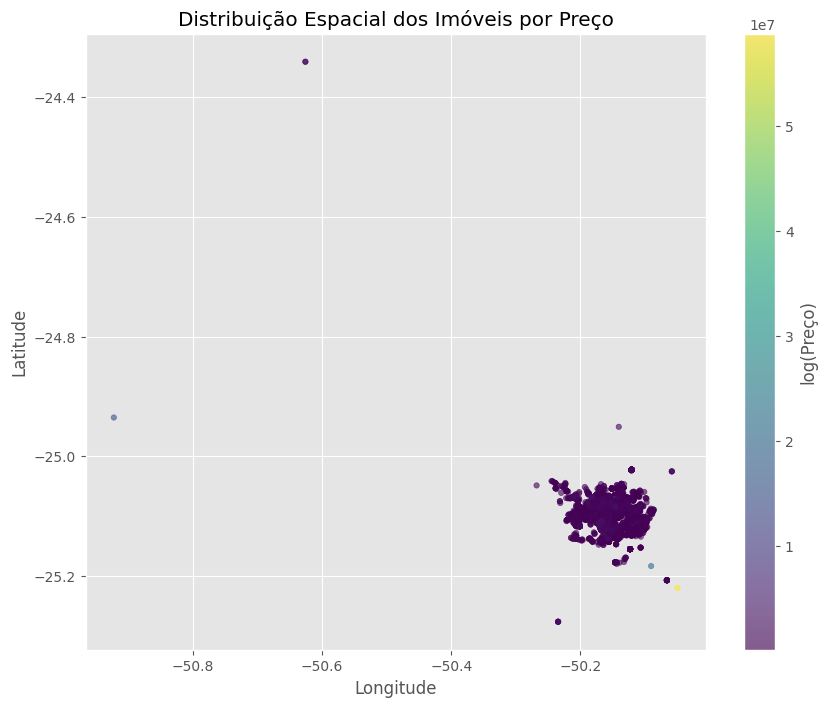

In [51]:
plt.figure(figsize=(10,8))
sc = plt.scatter(
    df['lon'],
    df['lat'],
    c=df['preco'],
    cmap='viridis',
    alpha=0.6,
    s=15
)

plt.colorbar(sc, label='log(Preço)')
plt.title('Distribuição Espacial dos Imóveis por Preço')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


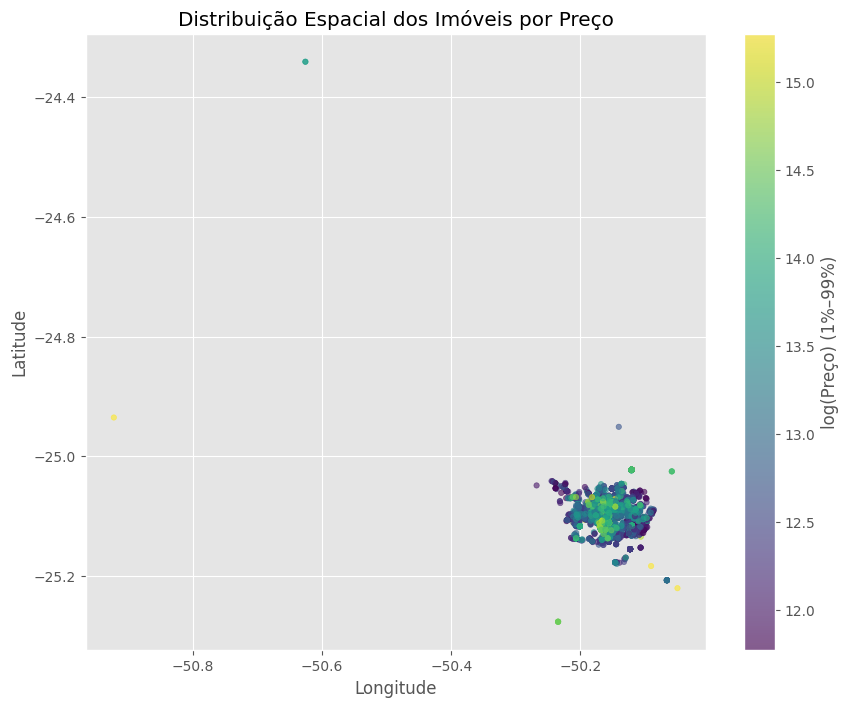

In [54]:
p1, p99 = df['log_preco'].quantile([0.01, 0.99])

plt.figure(figsize=(10,8))
sc = plt.scatter(
    df['lon'],
    df['lat'],
    c=df['log_preco'],
    cmap='viridis',
    alpha=0.6,
    s=15,
    vmin=p1,
    vmax=p99
)

plt.colorbar(sc, label='log(Preço) (1%–99%)')
plt.title('Distribuição Espacial dos Imóveis por Preço')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Insights

Aqui pra baixo, irei escrever os principais insights. 

## 3️⃣ Análise Bivariada (com foco no PREÇO)

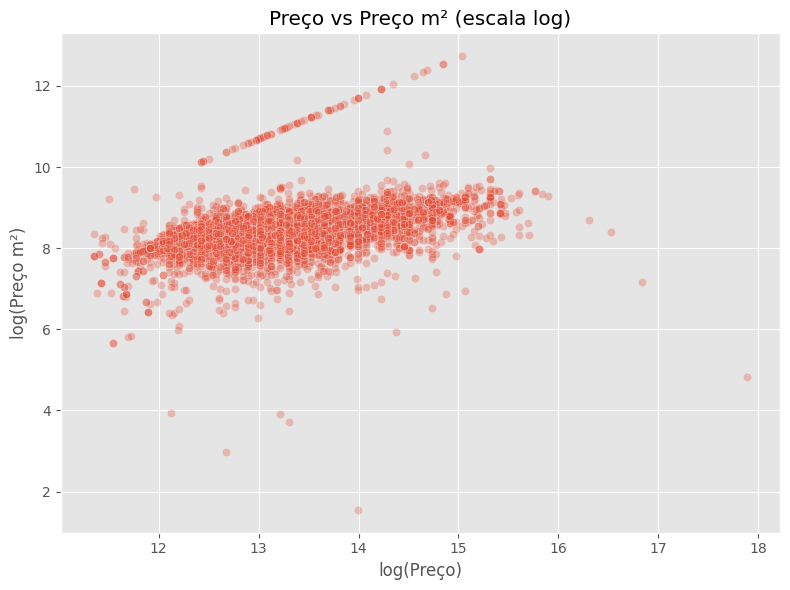

In [56]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=np.log1p(df["preco"]),
    y=np.log1p(df["preco_m2"]),
    alpha=0.3
)

plt.xlabel("log(Preço)")
plt.ylabel("log(Preço m²)")
plt.title("Preço vs Preço m² (escala log)")
plt.tight_layout()
plt.show()


In [57]:
#criação dos score. Essa etapa será a ultima da EDA. 

import numpy as np

df['score_escola_privada'] = (
    1.2 * np.exp(-df['dist_escolas_privadas_mais_proximo'] / 600) +
    0.6 * df['qtd_escolas_privadas_500m']
)

df['score_escola_publica'] = (
    0.6 * np.exp(-df['dist_escola_publicas_mais_proximo'] / 600) +
    0.2 * df['qtd_escola_publicas_500m']
)


df['score_hospitais'] = (
    0.8 * np.exp(-df['dist_hospital_mais_proximo'] / 1200) +
    0.4 * df['qtd_hospital_1000m']
)


df['score_mercado'] = (
    1.0 * np.exp(-df['dist_mercado_mais_proximo'] / 400) +
    0.4 * df['qtd_mercado_500m']
)


df['score_farmacia'] = (
    0.6 * np.exp(-df['dist_farmacia_mais_proximo'] / 300) +
    0.2 * df['qtd_farmacia_300m']
)


df['score_parque'] = (
    1.2 * np.exp(-df['dist_parque_mais_proximo'] / 1200) +
    0.8 * df['qtd_parque_1000m']
)


df['score_seguranca'] = (
    1.0 * np.exp(-df['dist_policia_mais_proximo'] / 1500) +
    0.3 * df['qtd_policia_500m']
)

df['score_educacao'] = (
    df['score_escola_privada']
    - 0.2 * df['score_escola_publica']
)


df

,preco,quartos,banheiros,area_m2,cidade,estado,vagas_garagem,bairro,preco_m2,lat,...,log_preco,faixa_area,score_escola_privada,score_escola_publica,score_hospitais,score_mercado,score_farmacia,score_parque,score_seguranca,score_educacao
0,2300000,4,5,354,ponta-grossa,pr,2,Jardim Carvalho,6497.18,-25.02,...,14.65,200–400,0.00,0.00,0.03,0.00,0.00,0.07,0.01,0.00
3,350000,4,3,165,ponta-grossa,pr,2,Estrela,2121.21,-25.11,...,12.77,120–200,0.24,0.25,0.34,0.71,0.00,3.26,0.39,0.19
5,340000,3,2,80,ponta-grossa,pr,1,Oficinas,4250.00,-25.11,...,12.74,50–80,0.12,0.89,0.25,0.87,0.00,6.46,0.68,-0.06
18,750000,4,3,260,ponta-grossa,pr,2,Ronda,2884.62,-25.10,...,13.53,200–400,0.20,0.79,0.29,0.25,0.00,1.79,0.37,0.05
27,280000,3,1,141,ponta-grossa,pr,1,Jardim Carvalho,1985.82,-25.08,...,12.54,120–200,0.24,0.67,0.27,0.08,0.05,10.33,0.42,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,1450000,3,4,235,ponta-grossa,pr,2,Jardim Carvalho,6170.21,-25.02,...,14.19,200–400,0.00,0.00,0.03,0.00,0.00,0.07,0.01,0.00
8591,1500000,3,4,217,ponta-grossa,pr,2,Colônia Dona Luíza,6912.44,-25.12,...,14.22,200–400,0.11,0.80,0.79,0.29,0.00,3.85,0.37,-0.05
8593,2000000,8,5,370,ponta-grossa,pr,4,Boa Vista,5405.41,-25.08,...,14.51,200–400,0.19,0.25,0.29,0.12,0.00,5.08,1.08,0.14
8596,1310000,1,1,310,ponta-grossa,pr,2,Jardim Carvalho,4225.81,-25.08,...,14.09,200–400,0.29,0.73,0.26,0.19,0.46,6.57,0.36,0.14


In [58]:
df[[
    'score_escola_privada',
    'score_escola_publica',
    'score_educacao',
    'score_seguranca'
]].describe()

,score_escola_privada,score_escola_publica,score_educacao,score_seguranca
count,5806.00,5806.00,5806.00,5806.00
mean,0.71,0.53,0.60,0.54
std,0.84,0.33,0.83,0.44
min,0.00,0.00,-0.26,0.00
25%,0.12,0.23,0.03,0.23
50%,0.35,0.53,0.23,0.41
75%,1.21,0.73,1.08,0.65
max,4.11,1.38,3.92,1.97


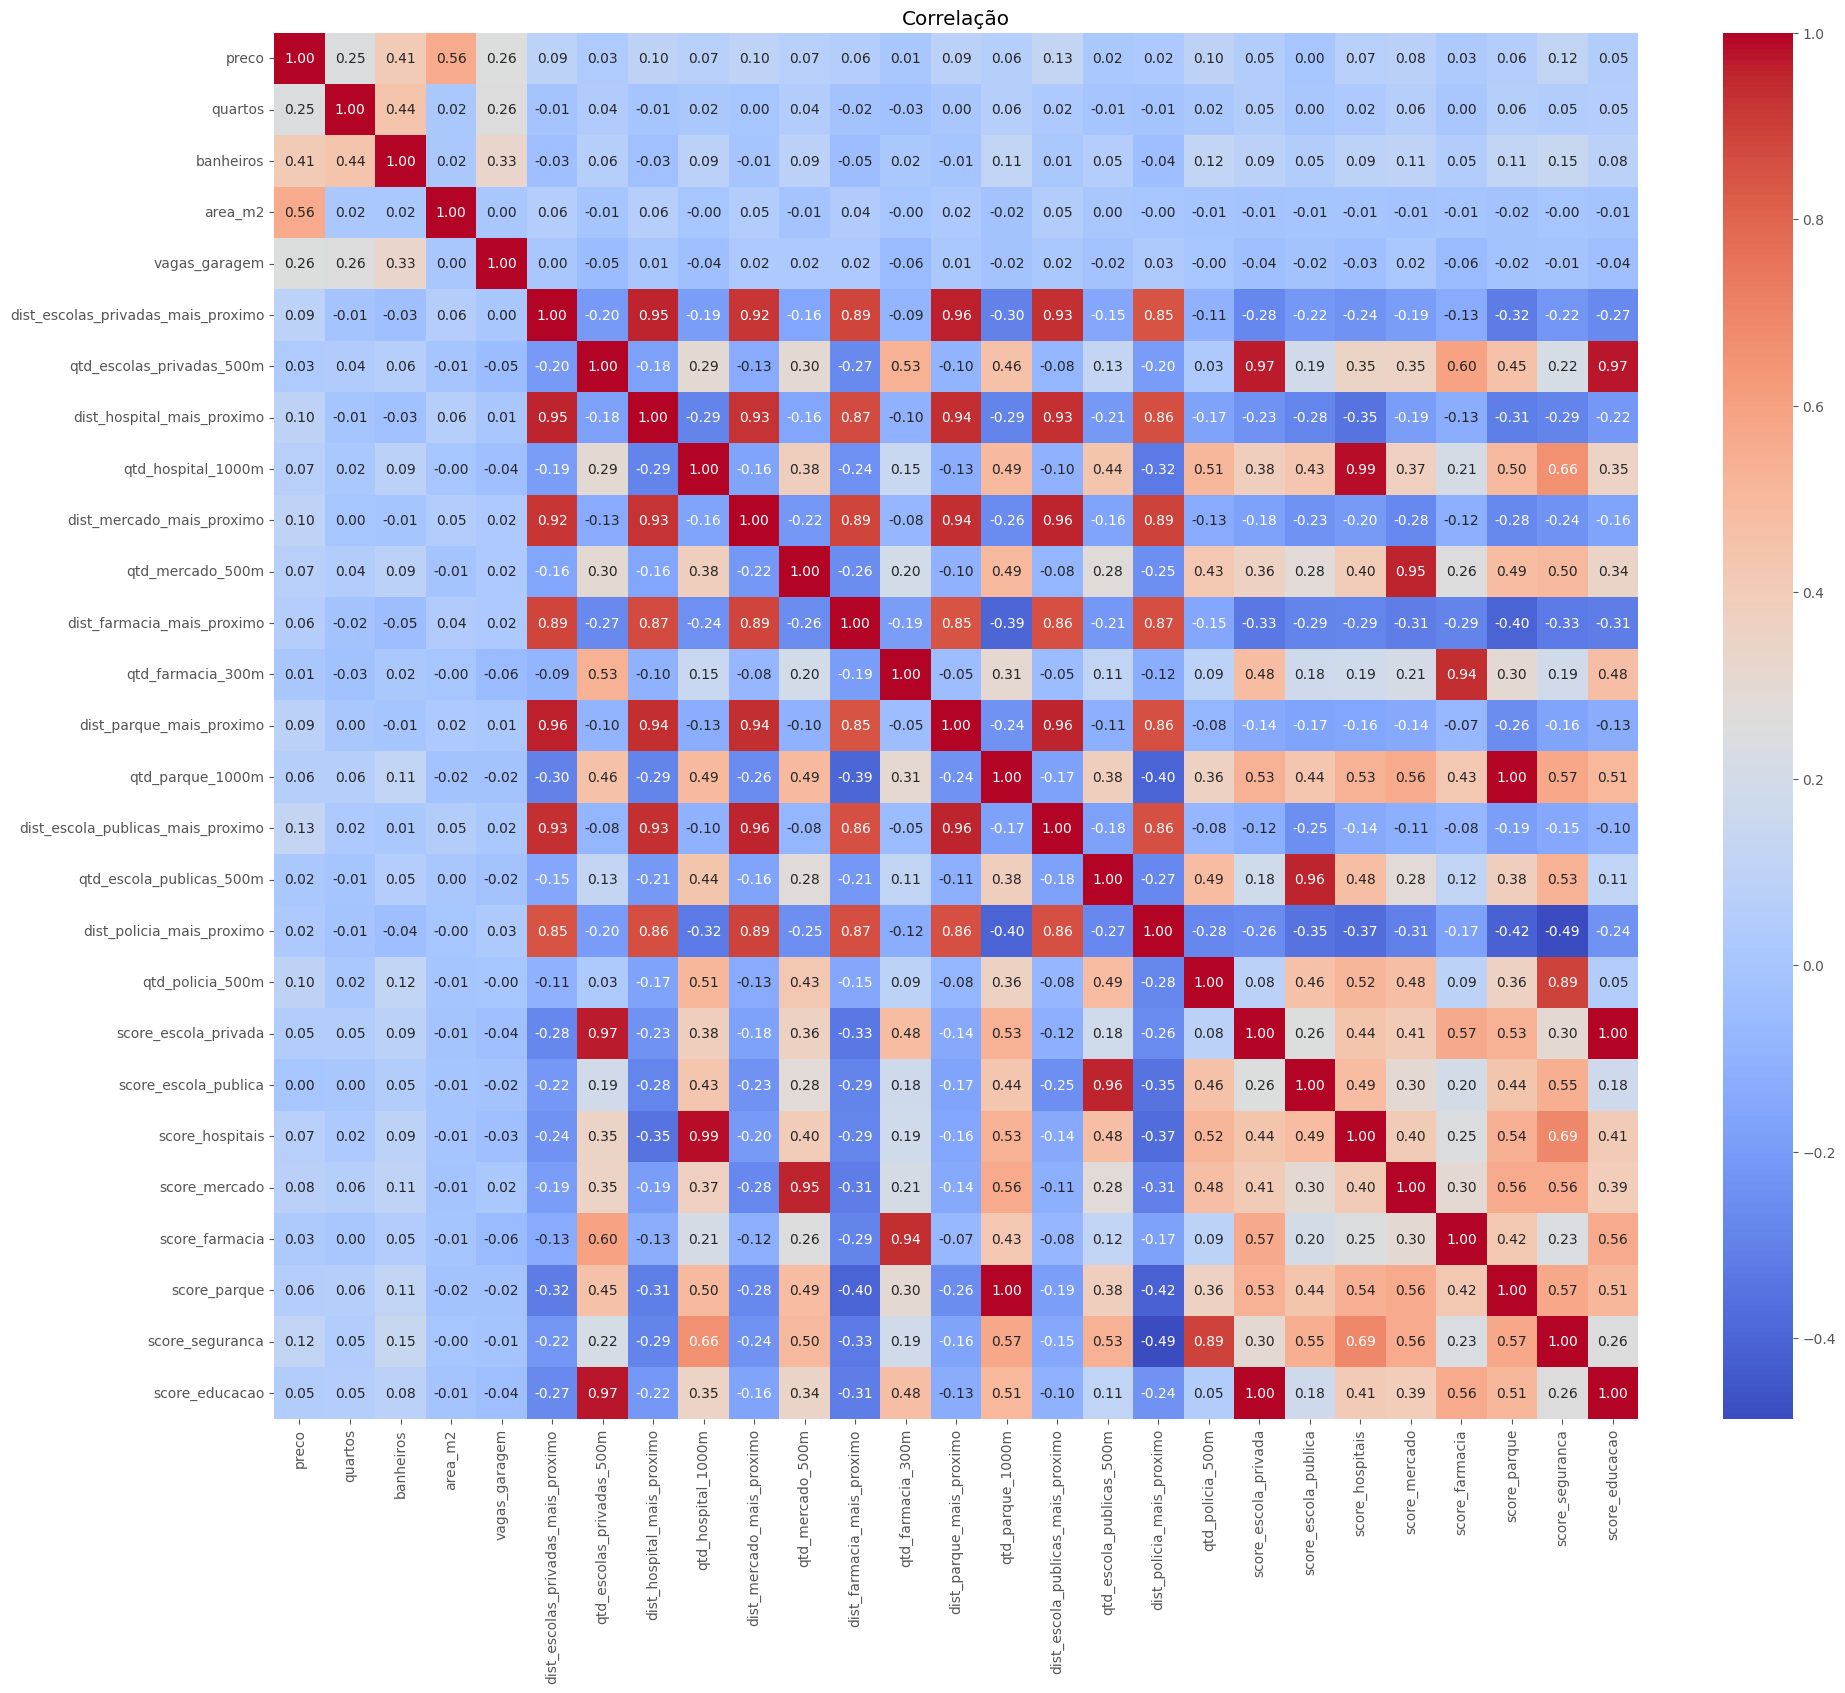

In [59]:
corr_cols = ['preco', 'quartos', 'banheiros', 'area_m2', 'vagas_garagem', 
        'dist_escolas_privadas_mais_proximo',
       'qtd_escolas_privadas_500m', 'dist_hospital_mais_proximo',
       'qtd_hospital_1000m', 'dist_mercado_mais_proximo', 'qtd_mercado_500m',
       'dist_farmacia_mais_proximo', 'qtd_farmacia_300m',
       'dist_parque_mais_proximo', 'qtd_parque_1000m',
       'dist_escola_publicas_mais_proximo', 'qtd_escola_publicas_500m',
       'dist_policia_mais_proximo', 'qtd_policia_500m',
       'score_escola_privada', 'score_escola_publica', 'score_hospitais',
       'score_mercado', 'score_farmacia', 'score_parque', 'score_seguranca',
       'score_educacao']

corr = df[corr_cols].corr()

plt.figure(figsize=(22, 18))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação")
plt.show()

## Testes de Inferência Estatística

#### Teste de Multicolinearidade

In [129]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

df1 = df.copy()

In [130]:
#del df1['log_preco']

In [140]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

features_base = [
    'quartos',
    'banheiros',
    'vagas_garagem',
    'area_m2',
    'score_escola_privada',
    'score_escola_publica',
    'score_hospitais',
    'score_mercado',
    'score_farmacia',
    'score_parque',
    'score_seguranca'
]

X = df1[features_base].copy()

# 🔑 CONVERSÃO CRÍTICA
X = X.astype(float)

X = sm.add_constant(X)

vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

vif_df.sort_values('VIF', ascending=False)


,feature,VIF
0,const,14.48
11,score_seguranca,2.79
7,score_hospitais,2.27
10,score_parque,2.16
5,score_escola_privada,1.95
8,score_mercado,1.76
9,score_farmacia,1.54
6,score_escola_publica,1.52
2,banheiros,1.36
1,quartos,1.27


In [141]:
print(vif_df)

                 feature   VIF
0                  const 14.48
1                quartos  1.27
2              banheiros  1.36
3          vagas_garagem  1.15
4                area_m2  1.00
5   score_escola_privada  1.95
6   score_escola_publica  1.52
7        score_hospitais  2.27
8          score_mercado  1.76
9         score_farmacia  1.54
10          score_parque  2.16
11       score_seguranca  2.79


### Teste de Multicolinearidade (VIF)

A multicolinearidade entre as variáveis explicativas foi avaliada por meio do Fator de Inflação da Variância (Variance Inflation Factor – VIF), utilizando como variável dependente o logaritmo do preço do imóvel (`log_preco`).

De forma geral, valores de VIF inferiores a 5 indicam ausência de multicolinearidade relevante, enquanto valores acima de 10 costumam ser interpretados como problemáticos.

Os resultados mostram que todas as variáveis explicativas apresentam VIFs baixos, variando aproximadamente entre 1.00 e 2.79, o que indica baixa correlação linear entre elas. Isso sugere que cada variável contribui de forma relativamente independente para a explicação do preço dos imóveis.

O valor elevado do VIF associado ao termo constante (VIF = 14.48) não é interpretado como um problema de multicolinearidade, pois o intercepto representa apenas o nível médio da variável dependente e não interfere na interpretação das relações entre as variáveis explicativas.

Assim, conclui-se que o modelo não sofre de multicolinearidade relevante, permitindo estimativas estáveis e interpretações confiáveis dos coeficientes.


### Anova

* **Objetivo:** Comparar as médias de uma variável contínua (ex.: preço) entre dois ou mais grupos categóricos (ex.: bairro e faixa_area).

* **Exemplo:** Verificar se o preço médio dos imóveis difere significativamente entre os bairos.


* **Pré-requisitos:**
* * A variável dependente (ex.: price) deve ser contínua.
* * Os dados devem ser aproximadamente normais em cada grupo.
* * As variâncias entre os grupos devem ser homogêneas (teste de Levene pode ser usado para checar isso).

In [77]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [81]:
model_bairro = ols(
    'log_preco ~ C(bairro)',
    data=df_anova
).fit()

anova_bairro = sm.stats.anova_lm(model_bairro, typ=2)
print(anova_bairro)

           sum_sq      df     F  PR(>F)
C(bairro)  574.41   15.00 70.22    0.00
Residual  3156.80 5789.00   NaN     NaN


### ANOVA – Efeito do Bairro sobre o Preço dos Imóveis

Foi realizada uma análise de variância (ANOVA de um fator) para avaliar se o logaritmo do preço dos imóveis (`log_preco`) difere significativamente entre os bairros.

O teste apresentou um valor de F elevado (F = 70.22) e um p-valor estatisticamente significativo (p < 0.001), levando à rejeição da hipótese nula de igualdade das médias.

Esse resultado indica que existem diferenças estatisticamente significativas no preço médio dos imóveis entre os bairros analisados, evidenciando a importância do fator locacional na formação dos preços imobiliários.


In [82]:
model_faixa = ols(
    'log_preco ~ C(faixa_area)',
    data=df_anova
).fit()

anova_faixa = sm.stats.anova_lm(model_faixa, typ=2)
print(anova_faixa)


               sum_sq      df       F  PR(>F)
C(faixa_area) 2337.97    5.00 1946.24    0.00
Residual      1393.24 5799.00     NaN     NaN


### ANOVA – Efeito da Faixa de Área sobre o Preço dos Imóveis

A ANOVA de um fator também foi aplicada para avaliar o impacto da variável categórica `faixa_area` sobre o logaritmo do preço dos imóveis (`log_preco`).

Os resultados indicam um efeito extremamente significativo da faixa de área, com um valor de F muito elevado (F = 1946.24) e p-valor inferior a 0.001.

Esse resultado sugere que o tamanho do imóvel, categorizado em faixas de área, é um dos principais determinantes do preço, explicando uma parcela substancial da variabilidade observada nos valores dos imóveis.


In [83]:
# Selecionar os dados e converter para tipos numpy padrão
df_anova = df[['log_preco', 'bairro', 'faixa_area']].dropna().copy()

# Converter colunas numéricas para float64 padrão do numpy
df_anova['log_preco'] = df_anova['log_preco'].astype(float)

# Garantir que colunas categóricas sejam strings/objects
df_anova['bairro'] = df_anova['bairro'].astype(str)
df_anova['faixa_area'] = df_anova['faixa_area'].astype(str)

# Agora o modelo deve funcionar
model = smf.ols('log_preco ~ C(bairro) + C(faixa_area)', data=df_anova).fit()

# Obter a tabela ANOVA
anova_results = anova_lm(model, typ=2)
print(anova_results)

               sum_sq      df       F  PR(>F)
C(bairro)      149.36   15.00   46.30    0.00
C(faixa_area) 1912.93    5.00 1779.02    0.00
Residual      1243.88 5784.00     NaN     NaN


### ANOVA de Dois Fatores – Bairro e Faixa de Área

Foi estimado um modelo de ANOVA de dois fatores considerando simultaneamente os efeitos do bairro e da faixa de área sobre o logaritmo do preço dos imóveis.

Ambos os fatores apresentaram efeitos estatisticamente significativos (p < 0.001), indicando que tanto o bairro quanto a faixa de área contribuem de forma independente para explicar as variações nos preços dos imóveis.

Esse resultado reforça a importância conjunta de características locacionais e estruturais na determinação do valor imobiliário.


In [85]:
model_interaction = ols(
    'log_preco ~ C(bairro) * C(faixa_area)',
    data=df_anova
).fit()

anova_interaction = sm.stats.anova_lm(model_interaction, typ=2)
print(anova_interaction)


                         sum_sq      df       F  PR(>F)
C(bairro)                149.36   15.00   48.84    0.00
C(faixa_area)           1912.93    5.00 1876.68    0.00
C(bairro):C(faixa_area)   80.02   75.00    5.23    0.00
Residual                1163.85 5709.00     NaN     NaN


### ANOVA com Interação – Bairro × Faixa de Área

Adicionalmente, foi estimado um modelo de ANOVA incluindo o termo de interação entre bairro e faixa de área, com o objetivo de avaliar se o efeito do tamanho do imóvel sobre o preço varia de acordo com o bairro.

O termo de interação apresentou resultado estatisticamente significativo (F = 5.23, p < 0.001), indicando que o impacto da faixa de área sobre o preço não é homogêneo entre os bairros.

Isso sugere que imóveis de tamanhos semelhantes podem apresentar valores distintos dependendo do bairro em que estão localizados, evidenciando uma relação não aditiva entre fatores locacionais e estruturais.


## 6️⃣ Verificação rápida dos pressupostos (mínimo aceitável)

### Normalidade dos resíduos

In [90]:
import scipy.stats as stats

stats.shapiro(model_faixa.resid.sample(5000))


ShapiroResult(statistic=0.9775373007809215, pvalue=2.1279540219647766e-27)

### Teste de Normalidade dos Resíduos

A normalidade dos resíduos foi avaliada por meio do teste de Shapiro-Wilk.

O teste resultou em um p-valor inferior a 0.05, indicando rejeição da hipótese nula de normalidade dos resíduos.

Entretanto, considerando o grande tamanho amostral, pequenas violações da normalidade são esperadas e não comprometem a validade dos testes de inferência, especialmente no contexto de modelos lineares e ANOVA, que são robustos a desvios moderados dessa suposição.


## Homocedasticidade (Levene)

In [89]:
from scipy.stats import levene

groups = [
    group['log_preco'].values
    for _, group in df_anova.groupby('faixa_area')
]

levene(*groups)


LeveneResult(statistic=60.93059914598486, pvalue=4.429273065936536e-62)

### Heterocedasticidade e Presença de Outliers

O teste de Levene indicou rejeição da hipótese nula de homocedasticidade, sugerindo a presença de variância não constante dos resíduos entre os grupos analisados.

Essa violação pode ser explicada, em grande parte, pela presença de outliers no conjunto de dados, especialmente imóveis de alto valor, que tendem a apresentar maior dispersão de preços em comparação aos imóveis de menor valor. Mesmo após a transformação logarítmica do preço (`log_preco`), observa-se que a variabilidade dos resíduos permanece maior nas faixas superiores de preço.

Esse comportamento é comum em dados imobiliários e reflete a própria dinâmica do mercado, no qual imóveis de alto padrão apresentam maior heterogeneidade de atributos não observados (acabamento, exclusividade, vista, entre outros).

Dado o tamanho amostral elevado e a robustez dos testes ANOVA e dos modelos lineares à heterocedasticidade moderada, os resultados permanecem informativos. Ainda assim, essa evidência reforça a importância de interpretar os coeficientes de forma cautelosa e considerar abordagens complementares, como o uso de erros-padrão robustos em modelos de regressão.


### Modelo Primário Econométrico para verificarmos a relação das variáveis

In [60]:
import numpy as np
import statsmodels.api as sm


In [61]:
df['log_preco'] = np.log(df['preco'].clip(lower=1))
df

,preco,quartos,banheiros,area_m2,cidade,estado,vagas_garagem,bairro,preco_m2,lat,...,log_preco,faixa_area,score_escola_privada,score_escola_publica,score_hospitais,score_mercado,score_farmacia,score_parque,score_seguranca,score_educacao
0,2300000,4,5,354,ponta-grossa,pr,2,Jardim Carvalho,6497.18,-25.02,...,14.65,200–400,0.00,0.00,0.03,0.00,0.00,0.07,0.01,0.00
3,350000,4,3,165,ponta-grossa,pr,2,Estrela,2121.21,-25.11,...,12.77,120–200,0.24,0.25,0.34,0.71,0.00,3.26,0.39,0.19
5,340000,3,2,80,ponta-grossa,pr,1,Oficinas,4250.00,-25.11,...,12.74,50–80,0.12,0.89,0.25,0.87,0.00,6.46,0.68,-0.06
18,750000,4,3,260,ponta-grossa,pr,2,Ronda,2884.62,-25.10,...,13.53,200–400,0.20,0.79,0.29,0.25,0.00,1.79,0.37,0.05
27,280000,3,1,141,ponta-grossa,pr,1,Jardim Carvalho,1985.82,-25.08,...,12.54,120–200,0.24,0.67,0.27,0.08,0.05,10.33,0.42,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8590,1450000,3,4,235,ponta-grossa,pr,2,Jardim Carvalho,6170.21,-25.02,...,14.19,200–400,0.00,0.00,0.03,0.00,0.00,0.07,0.01,0.00
8591,1500000,3,4,217,ponta-grossa,pr,2,Colônia Dona Luíza,6912.44,-25.12,...,14.22,200–400,0.11,0.80,0.79,0.29,0.00,3.85,0.37,-0.05
8593,2000000,8,5,370,ponta-grossa,pr,4,Boa Vista,5405.41,-25.08,...,14.51,200–400,0.19,0.25,0.29,0.12,0.00,5.08,1.08,0.14
8596,1310000,1,1,310,ponta-grossa,pr,2,Jardim Carvalho,4225.81,-25.08,...,14.09,200–400,0.29,0.73,0.26,0.19,0.46,6.57,0.36,0.14


In [65]:
features_base = [
    'quartos',
    'banheiros',
    'vagas_garagem',
    'area_m2',
    'score_escola_privada',
    'score_escola_publica',
    'score_hospitais',
    'score_mercado',
    'score_farmacia',
    'score_parque',
    'score_seguranca'
]

target = 'log_preco'

df_model = df[features_base + [target]].copy()

# Verificar os tipos das colunas
print("Tipos antes da conversão:")
print(df_model.dtypes)

# Converter todas as colunas para float64
df_model = df_model.astype(float)

print("\nTipos depois da conversão:")
print(df_model.dtypes)

# Verificar infinitos e valores nulos
print("\nValores infinitos:")
print(np.isinf(df_model).sum())
print("\nValores nulos:")
print(df_model.isnull().sum())

# Substituir infinitos por NaN e remover nulos
df_model = df_model.replace([np.inf, -np.inf], np.nan)
df_model = df_model.dropna()

Tipos antes da conversão:
quartos                   Int64
banheiros                 Int64
vagas_garagem             Int64
area_m2                   Int64
score_escola_privada    float64
score_escola_publica    float64
score_hospitais         float64
score_mercado           float64
score_farmacia          float64
score_parque            float64
score_seguranca         float64
log_preco               Float64
dtype: object

Tipos depois da conversão:
quartos                 float64
banheiros               float64
vagas_garagem           float64
area_m2                 float64
score_escola_privada    float64
score_escola_publica    float64
score_hospitais         float64
score_mercado           float64
score_farmacia          float64
score_parque            float64
score_seguranca         float64
log_preco               float64
dtype: object

Valores infinitos:
quartos                 0
banheiros               0
vagas_garagem           0
area_m2                 0
score_escola_privada    0


In [66]:
def fit_model(features):
    X = df_model[features]
    X = sm.add_constant(X)
    y = df_model['log_preco']
    
    model = sm.OLS(y, X).fit()
    return model

model_1 = fit_model(features_base)
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_preco   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     520.3
Date:                Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:25:10   Log-Likelihood:                -4960.2
No. Observations:                5806   AIC:                             9944.
Df Residuals:                    5794   BIC:                         1.002e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.9158 

In [91]:
import numpy as np

beta_0 = 11.9158
preco_base = np.exp(beta_0)

preco_base


149611.91693405027

### Interpretação do Modelo de Regressão

O modelo estimado utiliza o logaritmo natural do preço dos imóveis (`log_preco`) como variável dependente, o que permite interpretar os coeficientes como efeitos percentuais aproximados sobre o preço final.

O R² ajustado do modelo é de aproximadamente 49,6%, indicando que as variáveis estruturais e locacionais incluídas explicam cerca de metade da variação observada nos preços dos imóveis. Em mercados imobiliários reais, esse nível de explicação é considerado elevado, dada a presença de fatores subjetivos e não observados, como padrão de acabamento e estado de conservação.

### Interpretação da Constante
A constante do modelo é estimada em 11.9158 na escala logarítmica. Ao retornar esse valor para a escala original, obtém-se um preço-base implícito de aproximadamente R$ 149 mil.

Esse valor não deve ser interpretado como um preço médio observado no mercado, mas como o nível inicial da função de preços do modelo. A partir desse valor base, os efeitos marginais das variáveis explicativas ajustam o preço estimado do imóvel.

### Características Estruturais dos imóveis
Entre as variáveis estruturais, o número de banheiros apresenta o maior impacto marginal sobre o preço do imóvel. Um banheiro adicional está associado a um aumento médio de aproximadamente 28% no preço, mantendo-se constantes as demais variáveis. Esse resultado é estatisticamente significativo e indica que banheiros são um forte sinal de qualidade e conforto percebido pelo mercado.

O número de vagas de garagem também exerce influência relevante, com um impacto positivo de cerca de 8,5% no preço para cada vaga adicional, refletindo a valorização desse atributo em contextos urbanos.

O número de quartos, embora estatisticamente significativo no modelo estimado, apresenta um efeito marginal relativamente menor quando comparado aos banheiros, indicando que o mercado atribui maior valor à funcionalidade e ao conforto do que simplesmente ao número de dormitórios.

### Área construída
A área construída do imóvel apresenta efeito positivo e estatisticamente significativo sobre o preço. Cada metro quadrado adicional está associado a um aumento percentual pequeno, porém cumulativo, no valor do imóvel.

Esse resultado é consistente com a literatura e reforça que a metragem construída exerce influência direta sobre o preço, embora com retornos marginais decrescentes à medida que a área aumenta.

### Localização e Infraestrutura urbana
As variáveis relacionadas à infraestrutura urbana e pontos de interesse (POIs) revelam impactos heterogêneos sobre o preço dos imóveis.

O score de segurança apresenta um dos efeitos positivos mais expressivos do modelo, indicando que imóveis localizados em regiões percebidas como mais seguras tendem a ser significativamente mais valorizados.

O score de farmácias e o score de parques também apresentam efeitos positivos e estatisticamente significativos, sugerindo que a proximidade a serviços essenciais e áreas de lazer agrega valor ao imóvel.

Por outro lado, o score de escolas públicas apresenta efeito negativo e estatisticamente significativo, o que pode refletir correlação com regiões mais antigas, maior densidade urbana ou ruídos não observados associados a áreas com alta concentração de equipamentos públicos.

Os scores de hospitais e mercados, embora apresentem sinais positivos, não se mostraram estatisticamente significativos neste modelo, sugerindo que seu efeito pode estar sendo parcialmente capturado por outras variáveis locacionais correlacionadas.

### Distribuição dos Resíduos e Outliers
A análise dos resíduos indica assimetria e curtose elevadas, evidenciando a presença de outliers no conjunto de dados. Mesmo após a transformação logarítmica do preço, observa-se que imóveis de alto valor continuam exercendo influência relevante sobre a distribuição dos resíduos.

Esse comportamento é esperado em dados imobiliários e reflete a heterogeneidade intrínseca do mercado, especialmente no segmento de imóveis de alto padrão.


### 💡 Insight Executivo
De forma geral, os resultados indicam que, para maximizar o valor de revenda de um imóvel em Ponta Grossa, os investimentos mais eficientes estão associados ao aumento do número de banheiros e à localização em regiões com boa oferta de serviços essenciais e maior percepção de segurança, além da priorização da área construída em detrimento de outras características menos valorizadas pelo mercado.


## Conclusão

### Integração entre ANOVA e Modelos de Regressão

A análise inferencial foi conduzida combinando modelos de ANOVA e regressão linear, de forma complementar, com o objetivo de fornecer evidências consistentes sobre os determinantes do preço dos imóveis.

A ANOVA foi utilizada para identificar diferenças estatisticamente significativas nas médias do logaritmo do preço (`log_preco`) entre grupos definidos por variáveis categóricas, como bairro e faixa de área. Os resultados indicaram efeitos altamente significativos desses fatores, bem como uma interação estatisticamente relevante entre eles, evidenciando que o impacto do tamanho do imóvel varia de acordo com a localização.

Por sua vez, os modelos de regressão linear permitiram quantificar o efeito marginal de variáveis contínuas e estruturais, como número de quartos, banheiros, vagas de garagem, área construída e indicadores de infraestrutura urbana, controlando simultaneamente para múltiplos fatores.

A convergência dos resultados obtidos por meio da ANOVA e da regressão fortalece a interpretação dos achados: enquanto a ANOVA demonstra a existência de diferenças sistemáticas entre grupos, a regressão fornece estimativas direcionais e mensuráveis desses efeitos, reduzindo o risco de conclusões espúrias baseadas apenas em comparações de médias.

### Interpretação Causal e Limitações

Embora a análise não tenha sido conduzida em um desenho experimental, a combinação de ANOVA e regressão linear fornece evidência empírica consistente de relações estruturais entre características dos imóveis e seus preços.

A utilização do logaritmo do preço como variável dependente, aliada ao controle simultâneo de múltiplos fatores estruturais e locacionais, contribui para mitigar vieses de escala e heterogeneidade não observada.

Ainda assim, os resultados devem ser interpretados como associações condicionais e não como causalidade estrita, uma vez que fatores não observados — como qualidade do acabamento, estado de conservação e atributos subjetivos — podem influenciar simultaneamente os preços e algumas das variáveis explicativas.

Apesar dessas limitações, a consistência dos resultados entre diferentes abordagens estatísticas reforça a robustez das conclusões e fornece evidência sólida sobre os principais determinantes do valor dos imóveis analisados.

De forma geral, os resultados indicam que o preço dos imóveis é determinado por uma combinação complexa de fatores estruturais e locacionais, cuja influência varia de maneira significativa entre diferentes regiões e faixas de tamanho, refletindo a heterogeneidade intrínseca do mercado imobiliário.
